In [1]:
import os

from AttackingNotebook import Unet_without_trajectory_learning

# Set CUDA_VISIBLE_DEVICES to make only device 0 visible
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

# If you want to make multiple devices visible (e.g., devices 0 and 1)
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

# Optional: Set CUDA_DEVICE_ORDER for consistent device indexing
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# Now, import your deep learning library (e.g., PyTorch)
import torch

# Verify the device
if torch.cuda.is_available():
    print(f"CUDA is available. Using device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("CUDA is not available.")

CUDA is available. Using device: 0
Device name: NVIDIA RTX A6000


In [2]:
%matplotlib inline
# fastmri
import fastmri
from fastmri.data import subsample
from fastmri.data import transforms, mri_data
from fastmri.evaluate import ssim, psnr, nmse
from fastmri.losses import SSIMLoss
from fastmri.models import Unet
import logging
import pathlib
import random
import shutil
import time
import os
import sys

import numpy as np
import torch
import torchvision
from tensorboardX import SummaryWriter
from torch.nn import functional as F
from torch.utils.data import DataLoader
from common.args import Args
from data import transforms2
import matplotlib

matplotlib.use('Agg')
import matplotlib.pyplot as plt
from models.subsampling_model import Subsampling_Model
from scipy.spatial import distance_matrix
import scipy.io as sio
from common.utils import get_vel_acc
#from common.evaluate import psnr, ssim
from fastmri.losses import SSIMLoss

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F

import fastmri.models
from models.rec_models.unet_model import UnetModel
from models.rec_models.complex_unet import ComplexUnetModel
import data.transforms2 as transforms
from pytorch_nufft.nufft2 import nufft, nufft_adjoint
import numpy as np
from WaveformProjection.run_projection import proj_handler
import matplotlib.pylab as P
from models.rec_models.vision_transformer import VisionTransformer
from models.rec_models.recon_net import ReconNet
from models.rec_models.humus_net import HUMUSNet, HUMUSBlock
from models.VarBlock import VarNet
from typing import Tuple
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import apply_mask

import torch
import numpy as np

import pathlib
import random
import h5py
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision
import os
import torch

class SliceData(Dataset):
    def __init__(self, root, transform, challenge="multicoil", sample_rate=1, resolution=(320, 320)):
        assert challenge in ["singlecoil", "multicoil"], "Challenge must be 'singlecoil' or 'multicoil'"
        self.transform = transform
        self.challenge = challenge
        self.examples = []

        files = list(pathlib.Path(root).iterdir())
        if sample_rate < 1:
            random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]

        for fname in sorted(files):
            try:
                with h5py.File(fname, 'r') as data:
                    if "kspace" not in data:
                        continue  # Skip files without k-space data

                    kspace = data["kspace"]
                    if self.challenge == "multicoil":
                        if len(kspace.shape) != 4:  # Ensure it follows (num_slices, num_coils, height, width)
                            continue
                    else:
                        if len(kspace.shape) != 3:  # Ensure it follows (num_slices, height, width)
                            continue

                    num_slices = kspace.shape[0]
                    temp = [(fname, slice) for slice in range(5, num_slices - 2)]
                    for (fname, slice) in temp:
                        try:
                            with h5py.File(fname, 'r') as data:
                                kspace = data["kspace"][slice]
                                if "reconstruction_rss" in data:
                                    try:
                                        target = data["reconstruction_rss"][slice]
                                        self.transform(kspace, target, data.attrs, fname.name, slice, self.challenge)
                                        self.examples.append((fname, slice))
                                    except Exception as e:
                                        print(e)
                                        continue
                                else:
                                    continue
                        except Exception as e:
                            print(e)
                            continue
                    print(len(self.examples))
            except Exception as e:
                print(e)
                continue

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        fname, slice = self.examples[i]
        try:
            with h5py.File(fname, 'r') as data:
                kspace = data["kspace"][slice]
                if "reconstruction_rss" in data:
                    try:
                        target = data["reconstruction_rss"][slice]
                    except Exception as e:
                        print(e)
                        return None
                else:
                    target = None
                return self.transform(kspace, target, data.attrs, fname.name, slice, self.challenge)
        except Exception as e:
            print(e)
            return None


import torch.nn.functional as F
import torch
from torchvision import transforms as visonTransforms
from PIL import Image
import torch.nn.functional as F

def normalize(img):
    return (img - img.min()) / (img.max() - img.min() + 1e-8)

class DataTransform:
    def __init__(self, resolution):
        self.resolution = resolution
        self.resize_transform = visonTransforms.Resize((self.resolution, self.resolution))

    def __call__(self, kspace, target, attrs, fname, slice, challange="multicoil"):
        kspace = transforms.to_tensor(kspace)
        image = transforms.ifft2_regular(kspace)
        # Convert from two channels to complex
        if len(image.shape) == 4:
            image = image.permute(0, 3, 1, 2)
            if image.shape[-2] < self.resolution or image.shape[-1] < self.resolution:
                    image = F.interpolate(image, size=(self.resolution, self.resolution), mode='bilinear', align_corners=False)
            image = image.permute(0, 2, 3, 1)

        image = transforms.complex_center_crop(image, (self.resolution, self.resolution))
        #image, mean, std = transforms.normalize_instance(image, eps=1e-11)

        #print(image.shape)
        target = transforms.to_tensor(target)
        #target, mean, std = transforms.normalize_instance(target, eps=1e-11)
        mean = std = 0

        target = target.unsqueeze(0).unsqueeze(0)
        if target.shape[-2] < self.resolution or target.shape[-1] < self.resolution:
            target = F.interpolate(target, size=(self.resolution, self.resolution), mode='bilinear', align_corners=False)
        target = target.squeeze(0).squeeze(0)

        target = transforms.center_crop(target, (self.resolution, self.resolution))

        return fastmri.rss(image) if challange == "multicoil" else image, normalize(target), mean, std, target, attrs['max']



def create_knee_dataset(data_path, batch_size, sample_rate):
    dev_data = SliceData(
        root="knee/singlecoil_val",
        challenge="singlecoil",
        transform=DataTransform(320),
        sample_rate=sample_rate)
    return dev_data

def create_m4raw_dataset(data_path, batch_size, sample_rate):
    dev_data = SliceData(
        root= f'm4raw/multicoil_val',
        challenge="multicoil",
        transform=DataTransform(320),
        sample_rate=sample_rate)
    return dev_data

def create_datasets(data_path, batch_size, sample_rate, test):
    dev_data = SliceData(
        root=data_path + (f'/multicoil_val' if not test else f'/multicoil_test_full'),
        challenge="multicoil",
        transform=DataTransform(320),
        sample_rate=sample_rate)


    return dev_data

def create_data_loaders(data_path, batch_size, sample_rate, test = False,knee = False, m4raw = False):
    if knee:
        dev_data = create_knee_dataset(data_path, batch_size, sample_rate)
    elif m4raw:
        dev_data = create_m4raw_dataset(data_path, batch_size, sample_rate)
    else:
        dev_data = create_datasets(data_path, batch_size, sample_rate, test)

    dev_loader = DataLoader(
        dataset=dev_data,
        batch_size=batch_size,
        num_workers=20,
        pin_memory=True,
    )
    return dev_loader


def build_model(args):
    print(f"reconstructing : {args.model}")
    model = Subsampling_Model(
        in_chans=args.in_chans,
        out_chans=args.out_chans,
        chans=args.num_chans,
        num_pool_layers=args.num_pools,
        drop_prob=args.drop_prob,
        decimation_rate=args.decimation_rate,
        res=args.resolution,
        trajectory_learning=args.trajectory_learning,
        initialization=args.initialization,
        SNR=args.SNR,
        n_shots=args.n_shots,
        interp_gap= 1,
        type=args.model,
        img_size=args.img_size,
        window_size=args.window_size,
        embed_dim=args.embed_dim,
        num_blocks=args.num_blocks,
        sample_per_shot=args.sample_per_shot
    ).to(args.device)
    return model

def load_model(checkpoint_file):
    print(checkpoint_file)
    checkpoint = torch.load(checkpoint_file)
    print(checkpoint["epoch"])
    args = checkpoint['args']
    args.trajectory_learning = 1
    model = build_model(args)
    if args.data_parallel:
        model = torch.nn.DataParallel(model)
    model.load_state_dict(checkpoint['model'])
    optimizer = build_optim(args, model)
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.eval()
    return model

def build_optim(args, model):
    optimizer = torch.optim.Adam([{'params': model.module.subsampling.parameters(), 'lr': args.sub_lr},
                                  {'params': model.module.reconstruction_model.parameters()}], args.lr)
    return optimizer

def get_first_batch(dataloader):
    """
    Get the first example from the DataLoader without iteration.

    Args:
    - dataloader: PyTorch DataLoader object

    Returns:
    - first_input: The first input example in the dataset.
    - first_label: The label for the first input example.
    """
    inputs, labels, _, _, _, m = next(iter(dataloader))
    first_input = inputs
    first_target = labels

    return first_input, first_target


import torch
import torchvision
import matplotlib.pyplot as plt
import os
from torchvision.transforms import Resize, ToPILImage

def show_image(source):
    %matplotlib inline
    source = source.clone()
    source.reshape(320,320)
    image = source
    image -= image.min()
    max_val = image.max()
    if max_val > 0:
        image /= max_val
    source = image
    grid = torchvision.utils.make_grid(source, nrow=4, pad_value=1)
    numpy_image = grid.permute(1, 2, 0).cpu().detach().numpy()

    # Save or display the image
    plt.imshow(numpy_image)
    plt.axis('off')
    plt.show()

/home/mohammedw/miniconda3/envs/mpilot-py310/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mohammedw/miniconda3/envs/mpilot-py310/lib/python3.12/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/mohammedw/miniconda3/envs/mpilot-py310/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
dev_loader = create_data_loaders("/mnt/walkure_public/users/mohammedw/fastmri_downloads", batch_size = 1, sample_rate = 0.05)
#args.sample_rate = 0.01

9
18
27
36
45
54
61
70
79
88
97
106
115
124
133
142
151


In [4]:
knee_loader = create_data_loaders("/mnt/walkure_public/users/mohammedw/fastmri_downloads", batch_size = 1, sample_rate = 0.1, knee =1)

25
48
73
106
139
173
201
230
258
289
316
343
376
409
436
464
494
521
548
583


In [19]:
test_loader = create_data_loaders("/mnt/walkure_public/users/mohammedw/fastmri_downloads", batch_size = 1, sample_rate = 0.1, test = True)

9
18
25
32
41
50
59
68
77
86
95
104
113
122
131
140
149
158
167
176
185
194
203
212
221
230
239
248
257
266
275
284
293
302


In [19]:
m4raw_loader = create_data_loaders("/mnt/walkure_public/users/mohammedw/fastmri_downloads", batch_size = 1, sample_rate = 0.05, m4raw = True)

11
22
33
44
55
66
77
88
99
110
121
132


In [5]:
def name_to_path(n):
    return f"/home/mohammedw/PycharmProjects/MPILOT/summary/16/{n}/best_model.pt"

Unet_without_trajectory_learning_radial = load_model(name_to_path("radial_1_16_1600_0.0005_fixed_Unet_40"))
Unet_trajectory_learning_radial = load_model(name_to_path("radial_1_16_1600_0.0005_0.005_0.005_0.001_changing_downwards_10_Unet_40"))
Unet_trajectory_learning_radial_noise_path_radial = load_model(name_to_path("radial_1_16_1600_0.0005_0.005_0.005_0.001_changing_downwards_20_10_Unet_40_linear_noise_intensity_80_noise_p_0.5"))
Unet_trajectory_learning_radial_noise_path_radial_adv = load_model(name_to_path("radial_1_16_1600_0.0005_0.005_0.005_0.001_changing_downwards_20_10_Unet_40__radial_pgd_intensity_1_noise_p_0.5"))
Unet_trajectory_learning_radial_noise_image_radial = load_model(name_to_path(("radial_1_16_1600_0.0005_0.005_0.005_0.001_changing_downwards_20_10_Unet_40_image_std_0_std_image6e-05_noise_p_0.5")))

Unet_trajectory_learning_cartesian = load_model(name_to_path("cartesian_4_0.08_0.0005_0.1_0.005_0.001_changing_downwards_10_Unet_40"))
Unet_trajectory_learning_cartesian_noise_image = load_model(name_to_path("cartesian_1_4_0.08_0.0005_0.05_0.005_0.001_changing_downwards_20_10_Unet_40_image_std_0_std_image6e-05_noise_p_0.5"))
Unet_trajectory_learning_cartesian_noise_path = load_model(name_to_path("cartesian_1_4_0.08_0.0005_0.05_0.005_0.001_changing_downwards_20_10_Unet_40_noise_std_20_std_image0_noise_p_0.5"))

Vit_l_with_trajectory_learning_radial = load_model(name_to_path("radial_16_1600_0.0005_0.01_0.005_0.001_changing_downwards_10_vit-l_40"))
Vit_l_without_trajectory_learning_radial = load_model(name_to_path("radial_1_16_1600_0.0005_fixed_vit-l_40"))
Vit_l_with_trajectory_learning_radial_noise_path = load_model(name_to_path("radial_1_16_1600_0.0005_0.01_0.005_0.001_changing_downwards_20_10_vit-l_40_noise_std_80_std_image0_noise_p_0.5"))
Vit_l_with_trajectory_learning_radial_noise_image = load_model(name_to_path("radial_1_16_1600_0.0005_0.01_0.005_0.001_changing_downwards_20_10_vit-l_40_image_std_0_std_image6e-05_noise_p_0.5"))

Vit_l_with_trajectory_learning_cartesian = load_model(name_to_path("cartesian_4_0.08_0.0001_0.1_0.005_0.001_changing_downwards_10_vit-l-pretrained-cartesian_30"))
Vit_l_without_trajectory_learning_cartesian = load_model(name_to_path("cartesian_4_0.08_0.0001_fixed_vit-l-pretrained-cartesian_30"))
Vit_l_with_trajectory_learning_cartesian_noise_image = load_model(name_to_path("cartesian_1_4_0.08_0.0005_0.1_0.005_0.001_changing_downwards_20_10_vit-l_40_image_std_0_std_image6e-05_noise_p_0.5"))
Vit_l_with_trajectory_learning_cartesian_noise_path = load_model(name_to_path("cartesian_1_4_0.08_0.0005_0.1_0.005_0.001_changing_downwards_20_10_vit-l_40_noise_std_20_std_image0_noise_p_0.5"))

/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_1_16_1600_0.0005_fixed_Unet_40/best_model.pt
8
reconstructing : Unet
1600
/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_1_16_1600_0.0005_0.005_0.005_0.001_changing_downwards_10_Unet_40/best_model.pt


/tmp/ipykernel_1986274/448587289.py:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file)


37
reconstructing : Unet
1600
/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_1_16_1600_0.0005_0.005_0.005_0.001_changing_downwards_20_10_Unet_40_linear_noise_intensity_80_noise_p_0.5/best_model.pt
10
reconstructing : Unet
1600
/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_1_16_1600_0.0005_0.005_0.005_0.001_changing_downwards_20_10_Unet_40__radial_pgd_intensity_1_noise_p_0.5/best_model.pt
10
reconstructing : Unet
1600
/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_1_16_1600_0.0005_0.005_0.005_0.001_changing_downwards_20_10_Unet_40_image_std_0_std_image6e-05_noise_p_0.5/best_model.pt
27
reconstructing : Unet
1600
/home/mohammedw/PycharmProjects/MPILOT/summary/16/cartesian_4_0.08_0.0005_0.1_0.005_0.001_changing_downwards_10_Unet_40/best_model.pt
39
reconstructing : Unet


/home/mohammedw/PycharmProjects/MPILOT/models/subsampling_model.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Bimask_1 = torch.tensor(mask)


/home/mohammedw/PycharmProjects/MPILOT/summary/16/cartesian_1_4_0.08_0.0005_0.05_0.005_0.001_changing_downwards_20_10_Unet_40_image_std_0_std_image6e-05_noise_p_0.5/best_model.pt
28
reconstructing : Unet
/home/mohammedw/PycharmProjects/MPILOT/summary/16/cartesian_1_4_0.08_0.0005_0.05_0.005_0.001_changing_downwards_20_10_Unet_40_noise_std_20_std_image0_noise_p_0.5/best_model.pt
23
reconstructing : Unet
/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_16_1600_0.0005_0.01_0.005_0.001_changing_downwards_10_vit-l_40/best_model.pt
39
reconstructing : vit-l
1600
/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_1_16_1600_0.0005_fixed_vit-l_40/best_model.pt
39
reconstructing : vit-l
1600
/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_1_16_1600_0.0005_0.01_0.005_0.001_changing_downwards_20_10_vit-l_40_noise_std_80_std_image0_noise_p_0.5/best_model.pt
27
reconstructing : vit-l
1600
/home/mohammedw/PycharmProjects/MPILOT/summary/16/radial_1_16_1600_0.0005_0.01_0.005_0.001

In [6]:
models_dict_radial_unet = {
    "Unet without trajectory learning radial": Unet_without_trajectory_learning_radial,
    "Unet trajectory learning radial": Unet_trajectory_learning_radial,
    "Unet trajectory learning radial with noise on the path":Unet_trajectory_learning_radial_noise_path_radial,
    "Unet trajectory learning radial with noise on the image": Unet_trajectory_learning_radial_noise_image_radial,
    "Unet with adv trajectory learning": Unet_trajectory_learning_radial_noise_path_radial_adv
}
models_dict_radial_vit = {
    "Vit-l with trajectory learning radial": Vit_l_with_trajectory_learning_radial,
    "Vit-l without trajectory learning radial": Vit_l_without_trajectory_learning_radial,
    "Vit-l with trajectory learning radial with noise on path":Vit_l_with_trajectory_learning_radial_noise_path,
    "Vit-l with trajectory learning radial with noise on image":Vit_l_with_trajectory_learning_radial_noise_image
}

In [7]:
models_dict_cartesian_unet = {
    "Unet trajectory learning cartesian": Unet_trajectory_learning_cartesian,
    "Unet trajectory learning cartesian with noise on image": Unet_trajectory_learning_cartesian_noise_image,
    "Unet trajectory learning cartesian with noise on path ":Unet_trajectory_learning_cartesian_noise_path,
}
models_dict_cartesian_vit= {
    "Vit-l with trajectory learning cartesian": Vit_l_with_trajectory_learning_cartesian,
    "Vit-l without trajectory learning cartesian": Vit_l_without_trajectory_learning_cartesian,
    "Vit-l with trajectory learning cartesian with noise on image":Vit_l_with_trajectory_learning_cartesian_noise_image,
    "Vit-l with trajectory learning cartesian with noise on path":Vit_l_with_trajectory_learning_cartesian_noise_path
}

In [37]:
models_dict_all = models_dict_radial_unet| models_dict_radial_vit | models_dict_cartesian_unet | models_dict_cartesian_vit

In [53]:
class CombinedModel(nn.Module):
    def __init__(self, model1: nn.Module, model2: nn.Module):
        super().__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        x = self.model1.module.subsampling(x)
        x = self.model2.module.reconstruction_model(x)
        return x.reshape(-1, 320, 320)

In [67]:
hyprid = {
    "with tl": CombinedModel(Vit_l_without_trajectory_learning_cartesian, Unet_trajectory_learning_cartesian),
    "with nosise on path": CombinedModel(Vit_l_without_trajectory_learning_cartesian, Unet_trajectory_learning_cartesian_noise_path),
    "with noise on path radial": CombinedModel(Vit_l_without_trajectory_learning_radial,Unet_trajectory_learning_radial_noise_path_radial),
    "tl path radial": CombinedModel(Vit_l_without_trajectory_learning_radial,Unet_trajectory_learning_radial_noise_path_radial),
}

In [ ]:
%matplotlib inline

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import savgol_filter
from common.evaluate import psnr
import fastmri


def compare_models(models_dict, dataloader):
    """
    Compares average PSNR for multiple models on a given dataloader.

    Args:
        models_dict: Dict of {'model_name': model}
        dataloader: DataLoader yielding (input_batch, target_batch, ...)
    """

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Model Comparison: PSNR", fontsize=16)

    colors = plt.cm.tab10(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd']
    line_styles = ['-', '--', ':', '-.']

    results = {}

    for i, (model_name, model) in enumerate(models_dict.items()):
        print(f"\nTesting model: {model_name}")
        model.eval()  # set model to eval mode
        total_psnr = 0
        num_batches = 0

        for input_batch, target_batch, *_ in tqdm(dataloader, desc=model_name):
            input_batch = input_batch.to("cuda")
            target_batch = target_batch.to("cuda")

            with torch.no_grad():
                output = model(input_batch.unsqueeze(0))

            # Assume input/output shapes: [B, C, H, W]
            for b in range(input_batch.size(0)):
                psnr_val = psnr(
                    target_batch[b].detach().cpu().numpy(),
                    output[b].detach().cpu().numpy()
                )
                total_psnr += psnr_val
                num_batches += 1

        avg_psnr = total_psnr / num_batches
        results[model_name] = avg_psnr

        # Plotting a single point for each model
        ax.plot([i], [avg_psnr],
                label=model_name,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                linestyle='')

    ax.set_xticks(range(len(models_dict)))
    ax.set_xticklabels(models_dict.keys(), rotation=15)
    ax.set_ylabel('PSNR (dB)', fontsize=12)
    ax.set_title('Average PSNR per Model')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

    %matplotlib inline
    plt.tight_layout()
    plt.show()

    return results

In [9]:
%matplotlib inline


Testing model: Unet trajectory learning radial


Unet trajectory learning radial: 100%|██████████| 300/300 [00:14<00:00, 20.58it/s]



Testing model: Vit-l with trajectory learning radial


Vit-l with trajectory learning radial: 100%|██████████| 300/300 [00:20<00:00, 14.76it/s]



Testing model: Vit-l without trajectory learning radial


Vit-l without trajectory learning radial: 100%|██████████| 300/300 [00:20<00:00, 14.87it/s]



Testing model: Unet trajectory learning radial with noise on the path


Unet trajectory learning radial with noise on the path: 100%|██████████| 300/300 [00:16<00:00, 18.61it/s]



Testing model: Unet trajectory learning radial with noise on the image


Unet trajectory learning radial with noise on the image: 100%|██████████| 300/300 [00:15<00:00, 19.11it/s]



Testing model: Vit-l with trajectory learning radial with noise on path


Vit-l with trajectory learning radial with noise on path: 100%|██████████| 300/300 [00:19<00:00, 15.53it/s]



Testing model: Vit-l with trajectory learning radial with noise on image


Vit-l with trajectory learning radial with noise on image: 100%|██████████| 300/300 [00:19<00:00, 15.18it/s]



Testing model: Unet trajectory learning cartesian


Unet trajectory learning cartesian: 100%|██████████| 300/300 [00:08<00:00, 33.45it/s]



Testing model: Vit-l with trajectory learning cartesian


Vit-l with trajectory learning cartesian: 100%|██████████| 300/300 [00:10<00:00, 28.07it/s]



Testing model: Vit-l without trajectory learning cartesian


Vit-l without trajectory learning cartesian: 100%|██████████| 300/300 [00:10<00:00, 27.30it/s]



Testing model: Vit-l with trajectory learning cartesian with noise on image


Vit-l with trajectory learning cartesian with noise on image: 100%|██████████| 300/300 [00:10<00:00, 28.09it/s]



Testing model: Unet trajectory learning cartesian with noise on image


Unet trajectory learning cartesian with noise on image: 100%|██████████| 300/300 [00:09<00:00, 33.10it/s]



Testing model: Unet trajectory learning cartesian with noise on path 


Unet trajectory learning cartesian with noise on path : 100%|██████████| 300/300 [00:08<00:00, 33.68it/s]



Testing model: Vit-l with trajectory learning cartesian with noise on path


Vit-l with trajectory learning cartesian with noise on path: 100%|██████████| 300/300 [00:10<00:00, 28.98it/s]


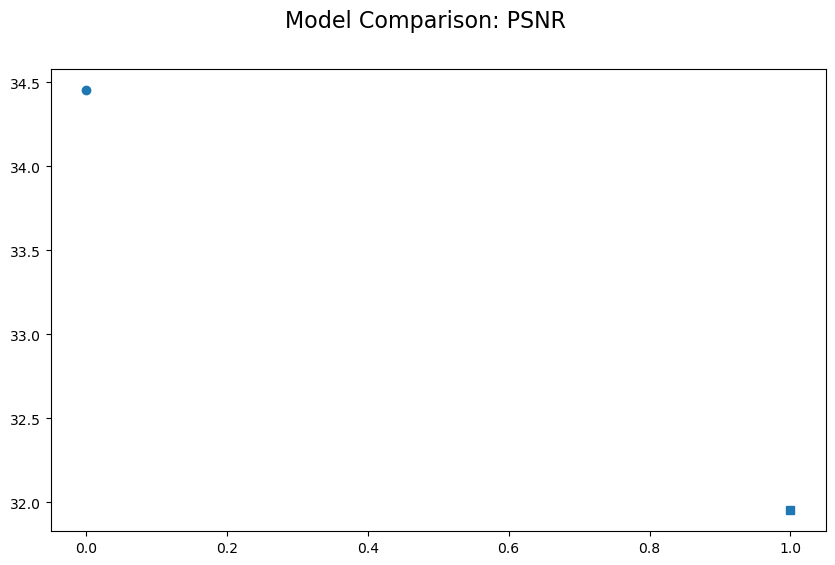

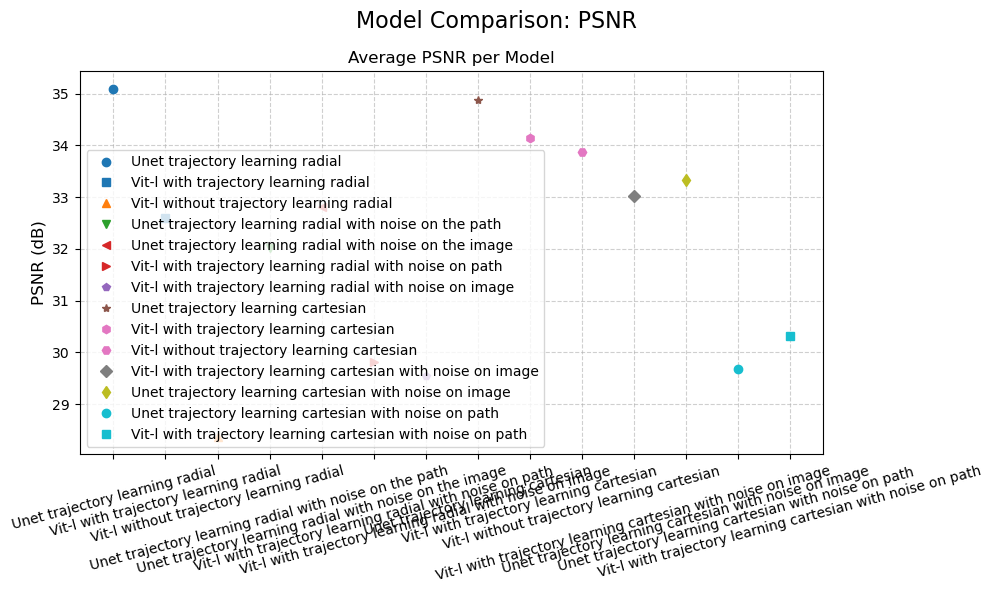

{'Unet trajectory learning radial': np.float64(35.095271451036815),
 'Vit-l with trajectory learning radial': np.float64(32.59868765994106),
 'Vit-l without trajectory learning radial': np.float64(28.368703321003025),
 'Unet trajectory learning radial with noise on the path': np.float64(32.022610644878704),
 'Unet trajectory learning radial with noise on the image': np.float64(32.80854119714428),
 'Vit-l with trajectory learning radial with noise on path': np.float64(29.81991361402296),
 'Vit-l with trajectory learning radial with noise on image': np.float64(29.550161593399437),
 'Unet trajectory learning cartesian': np.float64(34.88052732567623),
 'Vit-l with trajectory learning cartesian': np.float64(34.133907414739724),
 'Vit-l without trajectory learning cartesian': np.float64(33.87954486049873),
 'Vit-l with trajectory learning cartesian with noise on image': np.float64(33.02582819287056),
 'Unet trajectory learning cartesian with noise on image': np.float64(33.33575898932219),
 '

In [17]:
compare_models(models_dict_all, test_loader)

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from common.evaluate import psnr  # assuming returns scalar PSNR (dB)


def _avg_psnr_for_model(model, dataloader, device="cuda", desc="eval"):
    """
    Compute average PSNR (dB) for `model` over `dataloader`.
    Assumes dataloader yields (input_batch, target_batch, *rest).
    """
    model.eval()
    total = 0.0
    count = 0

    for batch in tqdm(dataloader, desc=desc):
        input_batch, target_batch, *rest = batch

        input_batch = input_batch.to(device, non_blocking=True)
        target_batch = target_batch.to(device, non_blocking=True)

        with torch.no_grad():
            output = model(input_batch.unsqueeze(0))  # no extra unsqueeze!

        # Expect shapes [B, ...]; loop over batch for PSNR
        # Convert per-sample to numpy; squeeze channel dim if present.
        out_np = output.detach().cpu().numpy()
        tgt_np = target_batch.detach().cpu().numpy()

        # Try to squeeze singleton channel dimension (e.g., [B,1,H,W] -> [B,H,W])
        if out_np.ndim == 4 and out_np.shape[1] == 1:
            out_np = out_np[:, 0, ...]
        if tgt_np.ndim == 4 and tgt_np.shape[1] == 1:
            tgt_np = tgt_np[:, 0, ...]

        # If still has >3 dims (e.g., complex reps), user may need to adapt.
        for b in range(out_np.shape[0]):
            total += psnr(tgt_np[b], out_np[b])
            count += 1

    return total / max(count, 1)


def compare_models_in_and_out(models_dict, dl_in, dl_out, device="cuda"):
    """
    Compare in-domain vs out-of-domain PSNR for each model.

    Args:
        models_dict: dict[str, nn.Module]
        dl_in:  in-domain DataLoader
        dl_out: out-of-domain DataLoader
        device: torch device (default 'cuda')

    Returns:
        results: dict[model_name] = {
            'in':  <avg_psnr_in>,
            'out': <avg_psnr_out>,
            'pct_change': <float | np.nan>
        }
    """
    results = {}

    # Precompute colors (same color for in & out of same model)
    n_models = len(models_dict)
    colors = plt.cm.tab10(np.linspace(0, 1, n_models))

    # Collect stats first (so plotting is clean)
    for i, (name, model) in enumerate(models_dict.items()):
        tqdm.write(f"\nEvaluating model: {name} (in-domain)")
        psnr_in = _avg_psnr_for_model(model, dl_in, device=device, desc=f"{name} (in)")

        tqdm.write(f"Evaluating model: {name} (out-of-domain)")
        psnr_out = _avg_psnr_for_model(model, dl_out, device=device, desc=f"{name} (out)")

        if psnr_in == 0:
            pct = np.nan
        else:
            pct = ((psnr_out - psnr_in) / psnr_in) * 100.0

        results[name] = {'in': psnr_in, 'out': psnr_out, 'pct_change': pct}

    # ---------------- Plot ----------------
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("In-domain vs Out-of-domain PSNR", fontsize=16)

    # X positions: one slot per model
    xs = np.arange(n_models)

    # Slight horizontal offsets so points don't overlap
    off = 0.15
    for i, (name, stats) in enumerate(results.items()):
        x_in = xs[i] - off
        x_out = xs[i] + off
        y_in = stats['in']
        y_out = stats['out']
        pct = stats['pct_change']

        color = colors[i % len(colors)]

        # scatter points
        ax.scatter(x_in, y_in, color=color, marker='o', label=None)
        ax.scatter(x_out, y_out, color=color, marker='^', label=None)

        # arrow from in -> out
        ax.annotate(
            "",  # no text here; text added separately
            xy=(x_out, y_out),
            xytext=(x_in, y_in),
            arrowprops=dict(arrowstyle="->", color=color, lw=1.5)
        )

        # percentage label mid-way
        xm = (x_in + x_out) / 2.0
        ym = (y_in + y_out) / 2.0
        if np.isnan(pct):
            txt = "n/a"
        else:
            sign = "+" if pct >= 0 else ""
            txt = f"{sign}{pct:.1f}%"
        ax.text(xm, ym, txt, fontsize=9, ha="center", va="bottom", color=color)

    # cosmetic axes
    ax.set_xticks(xs)
    ax.set_xticklabels(list(results.keys()), rotation=15)
    ax.set_ylabel("PSNR (dB)", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Custom legend (single entry for in/out markers)
    # Use dummy scatter handles
    h_in = ax.scatter([], [], marker='o', color='k', label='In-domain')
    h_out = ax.scatter([], [], marker='^', color='k', label='Out-of-domain')
    ax.legend(handles=[h_in, h_out], fontsize=10, loc="best")

    %matplotlib inline
    plt.tight_layout()
    plt.show()

    return results


Evaluating model: Unet without trajectory learning radial (in-domain)


Unet without trajectory learning radial (in): 100%|██████████| 151/151 [00:08<00:00, 17.27it/s]


Evaluating model: Unet without trajectory learning radial (out-of-domain)


Unet without trajectory learning radial (out): 100%|██████████| 132/132 [00:06<00:00, 18.88it/s]



Evaluating model: Unet trajectory learning radial (in-domain)


Unet trajectory learning radial (in): 100%|██████████| 151/151 [00:08<00:00, 18.55it/s]


Evaluating model: Unet trajectory learning radial (out-of-domain)


Unet trajectory learning radial (out): 100%|██████████| 132/132 [00:07<00:00, 18.27it/s]



Evaluating model: Unet trajectory learning radial with noise on the path (in-domain)


Unet trajectory learning radial with noise on the path (in): 100%|██████████| 151/151 [00:08<00:00, 18.04it/s]


Evaluating model: Unet trajectory learning radial with noise on the path (out-of-domain)


Unet trajectory learning radial with noise on the path (out): 100%|██████████| 132/132 [00:07<00:00, 18.18it/s]



Evaluating model: Unet trajectory learning radial with noise on the image (in-domain)


Unet trajectory learning radial with noise on the image (in): 100%|██████████| 151/151 [00:08<00:00, 17.08it/s]


Evaluating model: Unet trajectory learning radial with noise on the image (out-of-domain)


Unet trajectory learning radial with noise on the image (out): 100%|██████████| 132/132 [00:06<00:00, 20.20it/s]



Evaluating model: Unet with adv trajectory learning (in-domain)


Unet with adv trajectory learning (in): 100%|██████████| 151/151 [00:08<00:00, 17.79it/s]


Evaluating model: Unet with adv trajectory learning (out-of-domain)


Unet with adv trajectory learning (out): 100%|██████████| 132/132 [00:06<00:00, 19.91it/s]


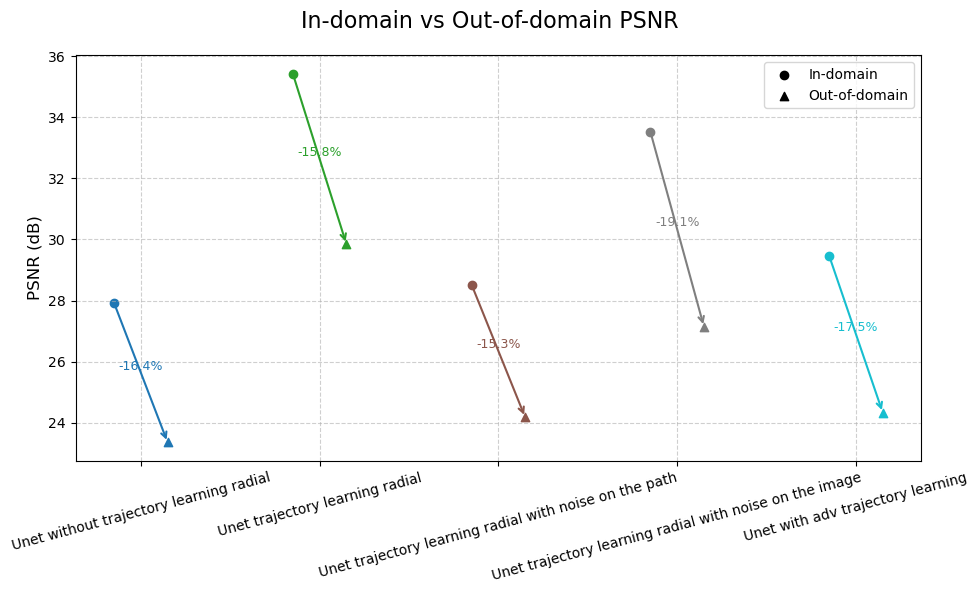

{'Unet without trajectory learning radial': {'in': np.float64(27.92441584429974),
  'out': np.float64(23.350753682859025),
  'pct_change': np.float64(-16.378720997933947)},
 'Unet trajectory learning radial': {'in': np.float64(35.43609159220447),
  'out': np.float64(29.84271739851596),
  'pct_change': np.float64(-15.784399301301583)},
 'Unet trajectory learning radial with noise on the path': {'in': np.float64(28.520793854857413),
  'out': np.float64(24.169444115717752),
  'pct_change': np.float64(-15.256762351299615)},
 'Unet trajectory learning radial with noise on the image': {'in': np.float64(33.5336196518543),
  'out': np.float64(27.13507867700747),
  'pct_change': np.float64(-19.080973188329857)},
 'Unet with adv trajectory learning': {'in': np.float64(29.46887872752105),
  'out': np.float64(24.32398767867816),
  'pct_change': np.float64(-17.458726870520746)}}

In [20]:
compare_models_in_and_out(models_dict_radial_unet, dev_loader, m4raw_loader)


Evaluating model: Unet without trajectory learning radial (in-domain)


Unet without trajectory learning radial (in): 100%|██████████| 151/151 [00:09<00:00, 15.60it/s]


Evaluating model: Unet without trajectory learning radial (out-of-domain)


Unet without trajectory learning radial (out): 100%|██████████| 583/583 [00:24<00:00, 23.86it/s]



Evaluating model: Unet trajectory learning radial (in-domain)


Unet trajectory learning radial (in): 100%|██████████| 151/151 [00:08<00:00, 18.27it/s]


Evaluating model: Unet trajectory learning radial (out-of-domain)


Unet trajectory learning radial (out): 100%|██████████| 583/583 [00:24<00:00, 24.12it/s]



Evaluating model: Unet trajectory learning radial with noise on the path (in-domain)


Unet trajectory learning radial with noise on the path (in): 100%|██████████| 151/151 [00:08<00:00, 18.72it/s]


Evaluating model: Unet trajectory learning radial with noise on the path (out-of-domain)


Unet trajectory learning radial with noise on the path (out): 100%|██████████| 583/583 [00:25<00:00, 23.15it/s]



Evaluating model: Unet trajectory learning radial with noise on the image (in-domain)


Unet trajectory learning radial with noise on the image (in): 100%|██████████| 151/151 [00:08<00:00, 18.60it/s]


Evaluating model: Unet trajectory learning radial with noise on the image (out-of-domain)


Unet trajectory learning radial with noise on the image (out): 100%|██████████| 583/583 [00:25<00:00, 22.99it/s]



Evaluating model: Unet with adv trajectory learning (in-domain)


Unet with adv trajectory learning (in): 100%|██████████| 151/151 [00:08<00:00, 17.79it/s]


Evaluating model: Unet with adv trajectory learning (out-of-domain)


Unet with adv trajectory learning (out): 100%|██████████| 583/583 [00:24<00:00, 24.27it/s]


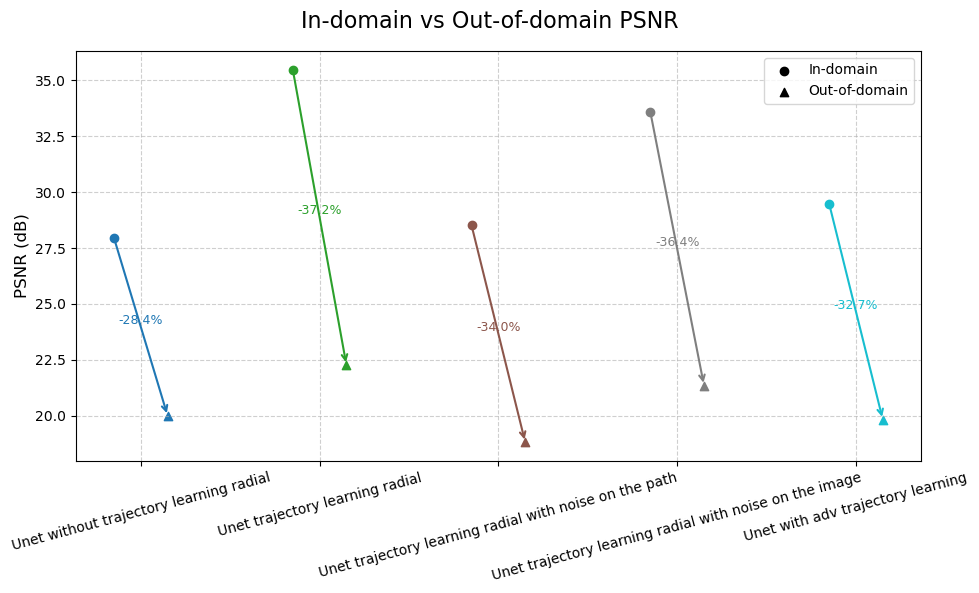

{'Unet without trajectory learning radial': {'in': np.float64(27.947146682213948),
  'out': np.float64(19.996467975710072),
  'pct_change': np.float64(-28.44898191901582)},
 'Unet trajectory learning radial': {'in': np.float64(35.47241328766682),
  'out': np.float64(22.265862452101054),
  'pct_change': np.float64(-37.23048310377424)},
 'Unet trajectory learning radial with noise on the path': {'in': np.float64(28.508782688517297),
  'out': np.float64(18.817988795958193),
  'pct_change': np.float64(-33.99231036428061)},
 'Unet trajectory learning radial with noise on the image': {'in': np.float64(33.575590457628685),
  'out': np.float64(21.35354108875962),
  'pct_change': np.float64(-36.40159175843206)},
 'Unet with adv trajectory learning': {'in': np.float64(29.480637694097044),
  'out': np.float64(19.830575960603607),
  'pct_change': np.float64(-32.733558322673886)}}

In [11]:
compare_models_in_and_out(models_dict_radial_unet, dev_loader, knee_loader)


Evaluating model: Vit-l with trajectory learning cartesian (in-domain)


Vit-l with trajectory learning cartesian (in): 100%|██████████| 300/300 [00:10<00:00, 28.83it/s]


Evaluating model: Vit-l with trajectory learning cartesian (out-of-domain)


Vit-l with trajectory learning cartesian (out): 100%|██████████| 584/584 [00:14<00:00, 39.53it/s]



Evaluating model: Vit-l without trajectory learning cartesian (in-domain)


Vit-l without trajectory learning cartesian (in): 100%|██████████| 300/300 [00:10<00:00, 29.11it/s]


Evaluating model: Vit-l without trajectory learning cartesian (out-of-domain)


Vit-l without trajectory learning cartesian (out): 100%|██████████| 584/584 [00:14<00:00, 40.38it/s]



Evaluating model: Vit-l with trajectory learning cartesian with noise on image (in-domain)


Vit-l with trajectory learning cartesian with noise on image (in): 100%|██████████| 300/300 [00:10<00:00, 29.68it/s]


Evaluating model: Vit-l with trajectory learning cartesian with noise on image (out-of-domain)


Vit-l with trajectory learning cartesian with noise on image (out): 100%|██████████| 584/584 [00:14<00:00, 41.02it/s]



Evaluating model: Vit-l with trajectory learning cartesian with noise on path (in-domain)


Vit-l with trajectory learning cartesian with noise on path (in): 100%|██████████| 300/300 [00:10<00:00, 28.51it/s]


Evaluating model: Vit-l with trajectory learning cartesian with noise on path (out-of-domain)


Vit-l with trajectory learning cartesian with noise on path (out): 100%|██████████| 584/584 [00:14<00:00, 40.68it/s]


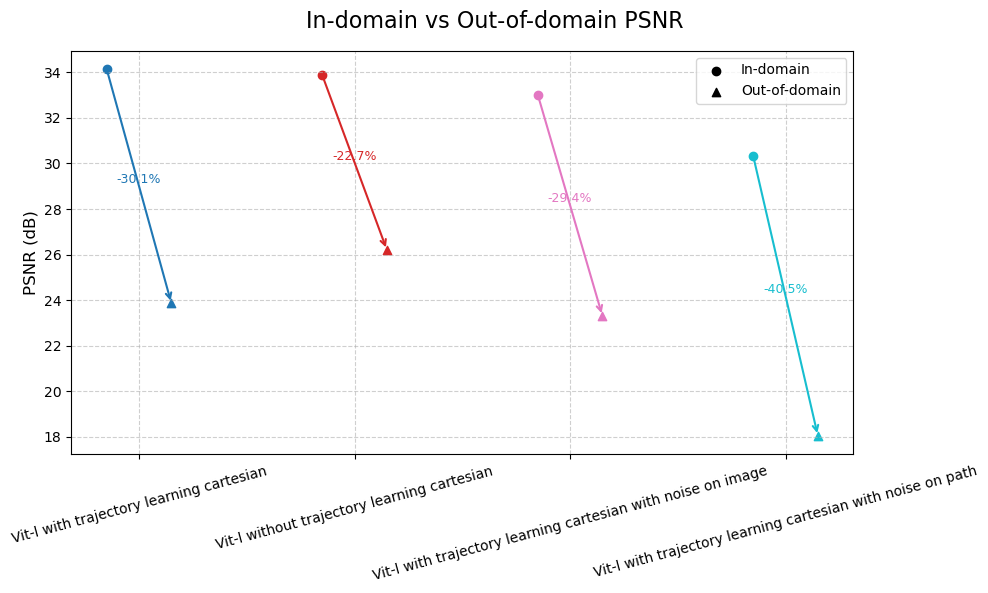

{'Vit-l with trajectory learning cartesian': {'in': np.float64(34.133907414739724),
  'out': np.float64(23.856056742546706),
  'pct_change': np.float64(-30.110384220925233)},
 'Vit-l without trajectory learning cartesian': {'in': np.float64(33.87954486049873),
  'out': np.float64(26.20036290629505),
  'pct_change': np.float64(-22.66613080495391)},
 'Vit-l with trajectory learning cartesian with noise on image': {'in': np.float64(33.02582819287056),
  'out': np.float64(23.30622476753589),
  'pct_change': np.float64(-29.430309418956185)},
 'Vit-l with trajectory learning cartesian with noise on path': {'in': np.float64(30.322629695554756),
  'out': np.float64(18.03919544044396),
  'pct_change': np.float64(-40.50913254700836)}}

In [23]:
compare_models_in_and_out(models_dict_cartesian_vit, test_loader, knee_loader)


Evaluating model: Vit-l with trajectory learning cartesian (in-domain)


Vit-l with trajectory learning cartesian (in): 100%|██████████| 302/302 [00:10<00:00, 27.56it/s]


Evaluating model: Vit-l with trajectory learning cartesian (out-of-domain)


Vit-l with trajectory learning cartesian (out): 100%|██████████| 528/528 [00:13<00:00, 40.18it/s]



Evaluating model: Vit-l without trajectory learning cartesian (in-domain)


Vit-l without trajectory learning cartesian (in): 100%|██████████| 302/302 [00:10<00:00, 28.42it/s]


Evaluating model: Vit-l without trajectory learning cartesian (out-of-domain)


Vit-l without trajectory learning cartesian (out): 100%|██████████| 528/528 [00:13<00:00, 40.01it/s]



Evaluating model: Vit-l with trajectory learning cartesian with noise on image (in-domain)


Vit-l with trajectory learning cartesian with noise on image (in): 100%|██████████| 302/302 [00:10<00:00, 28.02it/s]


Evaluating model: Vit-l with trajectory learning cartesian with noise on image (out-of-domain)


Vit-l with trajectory learning cartesian with noise on image (out): 100%|██████████| 528/528 [00:13<00:00, 39.25it/s]



Evaluating model: Vit-l with trajectory learning cartesian with noise on path (in-domain)


Vit-l with trajectory learning cartesian with noise on path (in): 100%|██████████| 302/302 [00:10<00:00, 28.00it/s]


Evaluating model: Vit-l with trajectory learning cartesian with noise on path (out-of-domain)


Vit-l with trajectory learning cartesian with noise on path (out): 100%|██████████| 528/528 [00:13<00:00, 40.10it/s]


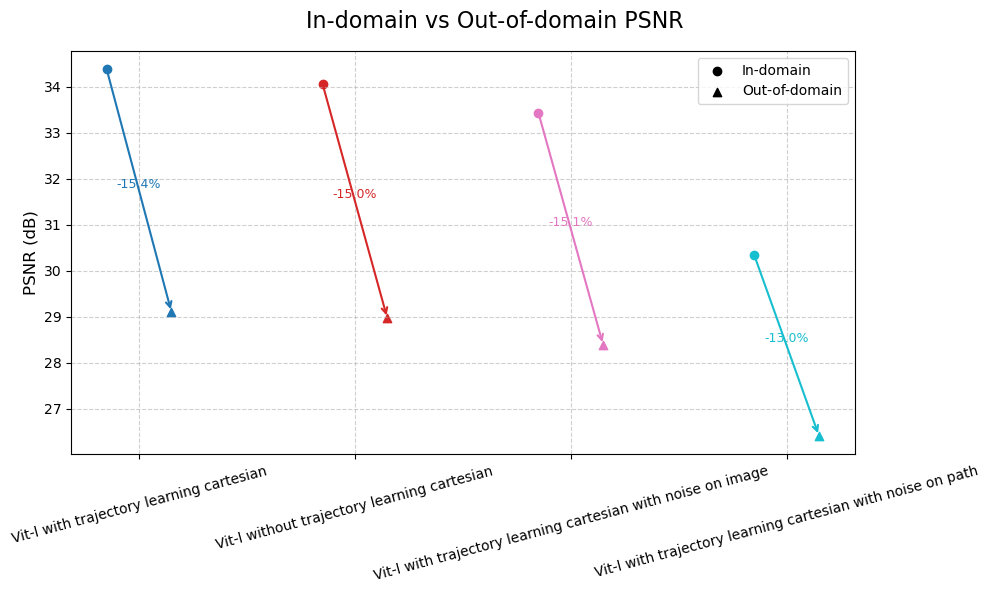

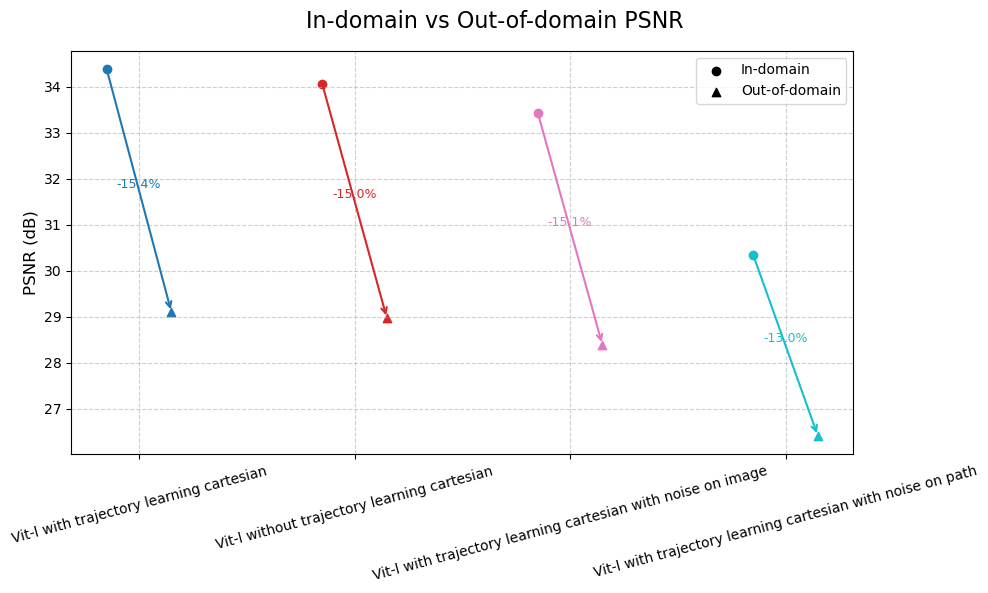

{'Vit-l with trajectory learning cartesian': {'in': np.float64(34.38402562100065),
  'out': np.float64(29.100648760643935),
  'pct_change': np.float64(-15.365789098091534)},
 'Vit-l without trajectory learning cartesian': {'in': np.float64(34.067004667654906),
  'out': np.float64(28.968327783332743),
  'pct_change': np.float64(-14.966613396343378)},
 'Vit-l with trajectory learning cartesian with noise on image': {'in': np.float64(33.44164223272598),
  'out': np.float64(28.388328076653266),
  'pct_change': np.float64(-15.110843304003604)},
 'Vit-l with trajectory learning cartesian with noise on path': {'in': np.float64(30.34184197914989),
  'out': np.float64(26.407175531356096),
  'pct_change': np.float64(-12.967790322346262)}}

In [24]:
compare_models_in_and_out(models_dict_cartesian_vit, test_loader, m4raw_loader)


Evaluating model: Unet trajectory learning cartesian (in-domain)


Unet trajectory learning cartesian (in): 100%|██████████| 300/300 [00:08<00:00, 34.30it/s]


Evaluating model: Unet trajectory learning cartesian (out-of-domain)


Unet trajectory learning cartesian (out): 100%|██████████| 584/584 [00:05<00:00, 100.92it/s]



Evaluating model: Unet trajectory learning cartesian with noise on image (in-domain)


Unet trajectory learning cartesian with noise on image (in): 100%|██████████| 300/300 [00:09<00:00, 31.24it/s]


Evaluating model: Unet trajectory learning cartesian with noise on image (out-of-domain)


Unet trajectory learning cartesian with noise on image (out): 100%|██████████| 584/584 [00:05<00:00, 107.24it/s]



Evaluating model: Unet trajectory learning cartesian with noise on path  (in-domain)


Unet trajectory learning cartesian with noise on path  (in): 100%|██████████| 300/300 [00:09<00:00, 32.64it/s]


Evaluating model: Unet trajectory learning cartesian with noise on path  (out-of-domain)


Unet trajectory learning cartesian with noise on path  (out): 100%|██████████| 584/584 [00:05<00:00, 115.97it/s]


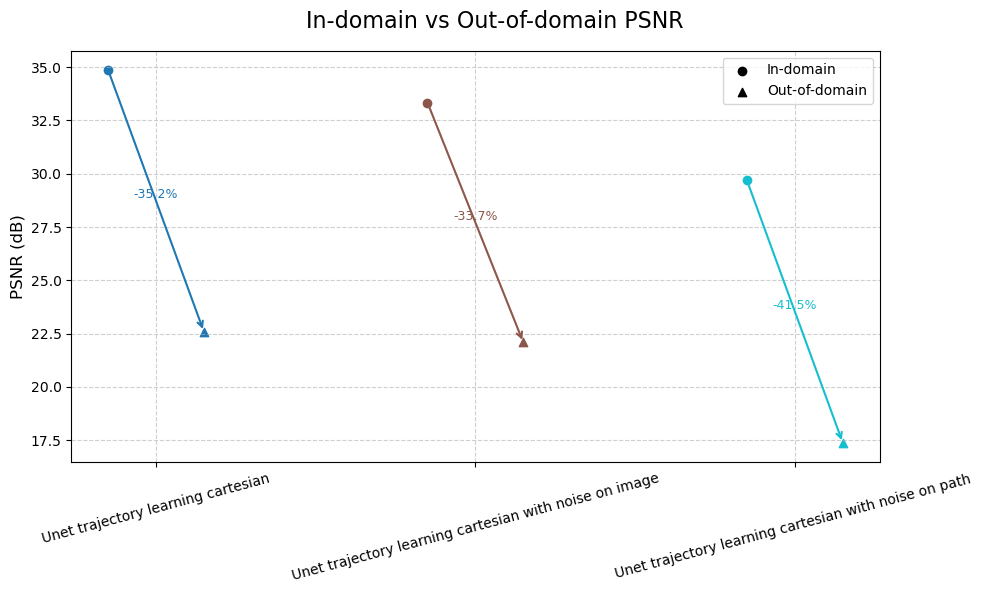

{'Unet trajectory learning cartesian': {'in': np.float64(34.88052732567623),
  'out': np.float64(22.5908704186085),
  'pct_change': np.float64(-35.23357543399603)},
 'Unet trajectory learning cartesian with noise on image': {'in': np.float64(33.33575898932219),
  'out': np.float64(22.085177578531695),
  'pct_change': np.float64(-33.7492883074724)},
 'Unet trajectory learning cartesian with noise on path ': {'in': np.float64(29.68840070064916),
  'out': np.float64(17.377761592150275),
  'pct_change': np.float64(-41.46615788646946)}}

In [24]:
compare_models_in_and_out(models_dict_cartesian_unet, test_loader, knee_loader)


Evaluating model: Unet trajectory learning cartesian (in-domain)


Unet trajectory learning cartesian (in): 100%|██████████| 302/302 [00:09<00:00, 30.43it/s]


Evaluating model: Unet trajectory learning cartesian (out-of-domain)


Unet trajectory learning cartesian (out): 100%|██████████| 528/528 [00:06<00:00, 85.57it/s] 



Evaluating model: Unet trajectory learning cartesian with noise on image (in-domain)


Unet trajectory learning cartesian with noise on image (in): 100%|██████████| 302/302 [00:09<00:00, 32.14it/s]


Evaluating model: Unet trajectory learning cartesian with noise on image (out-of-domain)


Unet trajectory learning cartesian with noise on image (out): 100%|██████████| 528/528 [00:05<00:00, 90.54it/s] 



Evaluating model: Unet trajectory learning cartesian with noise on path  (in-domain)


Unet trajectory learning cartesian with noise on path  (in): 100%|██████████| 302/302 [00:09<00:00, 31.81it/s]


Evaluating model: Unet trajectory learning cartesian with noise on path  (out-of-domain)


Unet trajectory learning cartesian with noise on path  (out): 100%|██████████| 528/528 [00:06<00:00, 85.03it/s] 


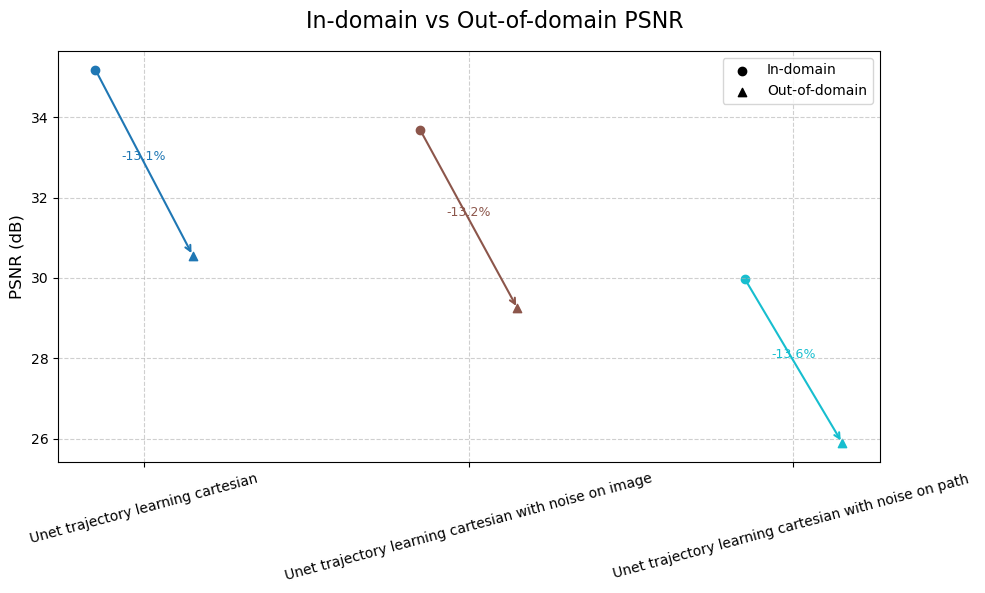

{'Unet trajectory learning cartesian': {'in': np.float64(35.182913232944756),
  'out': np.float64(30.55689509459555),
  'pct_change': np.float64(-13.148479512542105)},
 'Unet trajectory learning cartesian with noise on image': {'in': np.float64(33.687988836619596),
  'out': np.float64(29.24326251501928),
  'pct_change': np.float64(-13.193801337195888)},
 'Unet trajectory learning cartesian with noise on path ': {'in': np.float64(29.978737184074877),
  'out': np.float64(25.897371864724267),
  'pct_change': np.float64(-13.614200272313964)}}

In [25]:
compare_models_in_and_out(models_dict_cartesian_unet, test_loader, m4raw_loader)


Evaluating model: Unet trajectory learning radial (in-domain)


Unet trajectory learning radial (in): 100%|██████████| 300/300 [00:15<00:00, 19.63it/s]


Evaluating model: Unet trajectory learning radial (out-of-domain)


Unet trajectory learning radial (out): 100%|██████████| 584/584 [00:25<00:00, 22.92it/s]



Evaluating model: Unet trajectory learning radial with noise on the path (in-domain)


Unet trajectory learning radial with noise on the path (in): 100%|██████████| 300/300 [00:15<00:00, 19.59it/s]


Evaluating model: Unet trajectory learning radial with noise on the path (out-of-domain)


Unet trajectory learning radial with noise on the path (out): 100%|██████████| 584/584 [00:24<00:00, 23.94it/s]



Evaluating model: Unet trajectory learning radial with noise on the image (in-domain)


Unet trajectory learning radial with noise on the image (in): 100%|██████████| 300/300 [00:15<00:00, 19.69it/s]


Evaluating model: Unet trajectory learning radial with noise on the image (out-of-domain)


Unet trajectory learning radial with noise on the image (out): 100%|██████████| 584/584 [00:24<00:00, 23.84it/s]


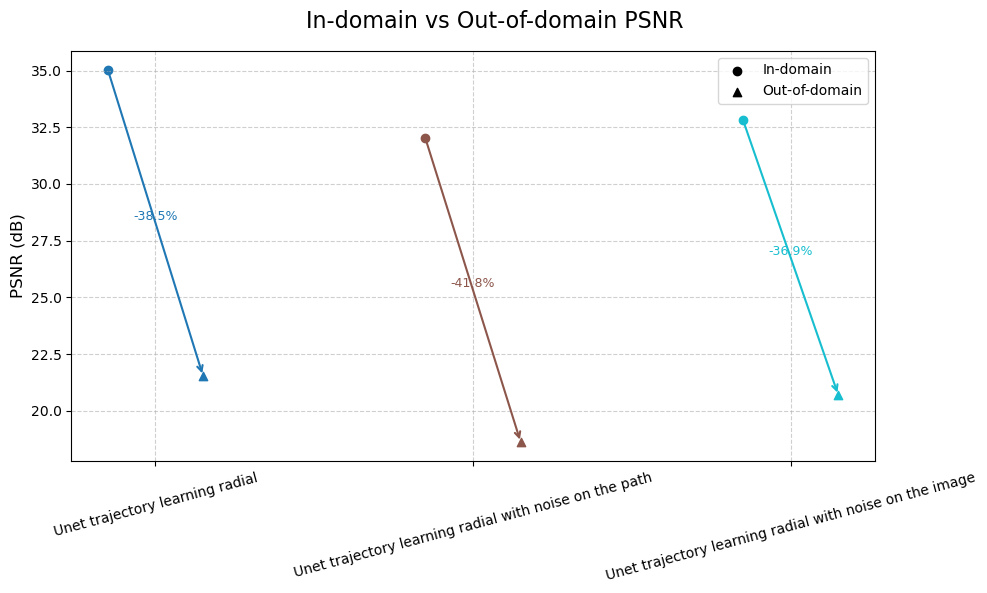

{'Unet trajectory learning radial': {'in': np.float64(35.0387486919607),
  'out': np.float64(21.535685589515563),
  'pct_change': np.float64(-38.537515198261865)},
 'Unet trajectory learning radial with noise on the path': {'in': np.float64(32.00849074818024),
  'out': np.float64(18.619035122783835),
  'pct_change': np.float64(-41.830949577519924)},
 'Unet trajectory learning radial with noise on the image': {'in': np.float64(32.8119401666401),
  'out': np.float64(20.692061994478205),
  'pct_change': np.float64(-36.93740178303804)}}

In [31]:
compare_models_in_and_out(models_dict_radial_unet, test_loader, knee_loader)


Evaluating model: Unet trajectory learning radial (in-domain)


Unet trajectory learning radial (in): 100%|██████████| 302/302 [00:16<00:00, 18.41it/s]


Evaluating model: Unet trajectory learning radial (out-of-domain)


Unet trajectory learning radial (out): 100%|██████████| 528/528 [00:22<00:00, 23.34it/s]



Evaluating model: Unet trajectory learning radial with noise on the path (in-domain)


Unet trajectory learning radial with noise on the path (in): 100%|██████████| 302/302 [00:16<00:00, 18.27it/s]


Evaluating model: Unet trajectory learning radial with noise on the path (out-of-domain)


Unet trajectory learning radial with noise on the path (out): 100%|██████████| 528/528 [00:23<00:00, 22.37it/s]



Evaluating model: Unet trajectory learning radial with noise on the image (in-domain)


Unet trajectory learning radial with noise on the image (in): 100%|██████████| 302/302 [00:16<00:00, 17.85it/s]


Evaluating model: Unet trajectory learning radial with noise on the image (out-of-domain)


Unet trajectory learning radial with noise on the image (out): 100%|██████████| 528/528 [00:22<00:00, 23.10it/s]


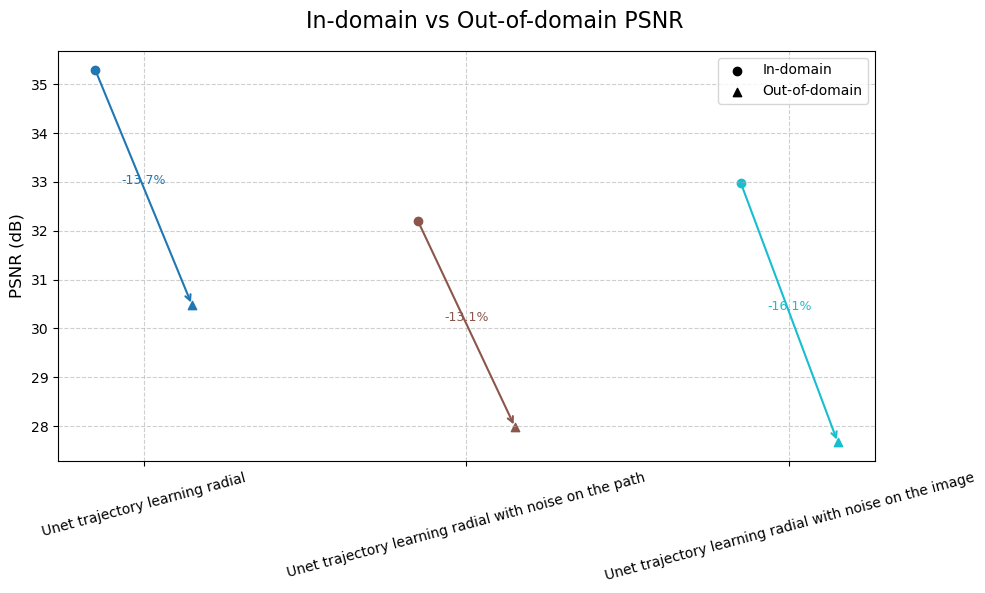

{'Unet trajectory learning radial': {'in': np.float64(35.29839248347843),
  'out': np.float64(30.477981321374177),
  'pct_change': np.float64(-13.65617758474545)},
 'Unet trajectory learning radial with noise on the path': {'in': np.float64(32.196054622419375),
  'out': np.float64(27.98445960694957),
  'pct_change': np.float64(-13.081090415771332)},
 'Unet trajectory learning radial with noise on the image': {'in': np.float64(32.97482901126032),
  'out': np.float64(27.670623612726715),
  'pct_change': np.float64(-16.085619114877932)}}

In [26]:
compare_models_in_and_out(models_dict_radial_unet, test_loader, m4raw_loader)


Evaluating model: Vit-l with trajectory learning radial (in-domain)


Vit-l with trajectory learning radial (in): 100%|██████████| 300/300 [00:19<00:00, 15.10it/s]


Evaluating model: Vit-l with trajectory learning radial (out-of-domain)


Vit-l with trajectory learning radial (out): 100%|██████████| 584/584 [00:34<00:00, 16.95it/s]



Evaluating model: Vit-l without trajectory learning radial (in-domain)


Vit-l without trajectory learning radial (in): 100%|██████████| 300/300 [00:19<00:00, 15.06it/s]


Evaluating model: Vit-l without trajectory learning radial (out-of-domain)


Vit-l without trajectory learning radial (out): 100%|██████████| 584/584 [00:33<00:00, 17.25it/s]



Evaluating model: Vit-l with trajectory learning radial with noise on path (in-domain)


Vit-l with trajectory learning radial with noise on path (in): 100%|██████████| 300/300 [00:19<00:00, 15.22it/s]


Evaluating model: Vit-l with trajectory learning radial with noise on path (out-of-domain)


Vit-l with trajectory learning radial with noise on path (out): 100%|██████████| 584/584 [00:34<00:00, 17.13it/s]



Evaluating model: Vit-l with trajectory learning radial with noise on image (in-domain)


Vit-l with trajectory learning radial with noise on image (in): 100%|██████████| 300/300 [00:19<00:00, 15.59it/s]


Evaluating model: Vit-l with trajectory learning radial with noise on image (out-of-domain)


Vit-l with trajectory learning radial with noise on image (out): 100%|██████████| 584/584 [00:34<00:00, 16.99it/s]


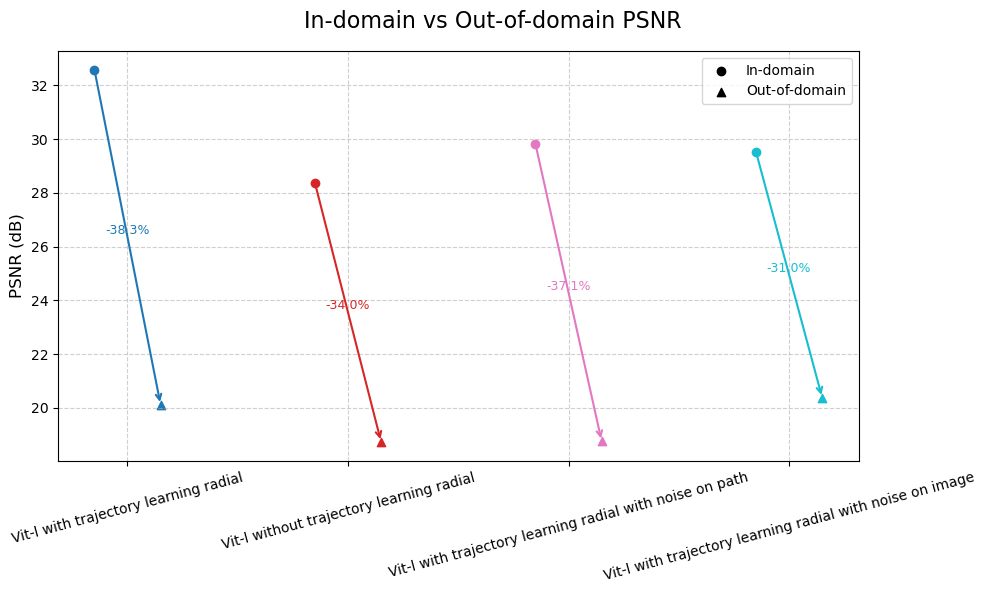

{'Vit-l with trajectory learning radial': {'in': np.float64(32.58779116791885),
  'out': np.float64(20.11695727791711),
  'pct_change': np.float64(-38.2684233667199)},
 'Vit-l without trajectory learning radial': {'in': np.float64(28.368560416621616),
  'out': np.float64(18.73057306388492),
  'pct_change': np.float64(-33.97418554622757)},
 'Vit-l with trajectory learning radial with noise on path': {'in': np.float64(29.81731232455079),
  'out': np.float64(18.75879669839003),
  'pct_change': np.float64(-37.087566799424344)},
 'Vit-l with trajectory learning radial with noise on image': {'in': np.float64(29.527149387209562),
  'out': np.float64(20.377892917775863),
  'pct_change': np.float64(-30.985911811036292)}}

In [32]:
compare_models_in_and_out(models_dict_radial_vit, test_loader, knee_loader)


Evaluating model: Vit-l with trajectory learning radial (in-domain)


Vit-l with trajectory learning radial (in): 100%|██████████| 302/302 [00:20<00:00, 14.53it/s]


Evaluating model: Vit-l with trajectory learning radial (out-of-domain)


Vit-l with trajectory learning radial (out): 100%|██████████| 528/528 [00:32<00:00, 16.49it/s]



Evaluating model: Vit-l without trajectory learning radial (in-domain)


Vit-l without trajectory learning radial (in): 100%|██████████| 302/302 [00:19<00:00, 15.11it/s]


Evaluating model: Vit-l without trajectory learning radial (out-of-domain)


Vit-l without trajectory learning radial (out): 100%|██████████| 528/528 [00:31<00:00, 16.67it/s]



Evaluating model: Vit-l with trajectory learning radial with noise on path (in-domain)


Vit-l with trajectory learning radial with noise on path (in): 100%|██████████| 302/302 [00:20<00:00, 14.85it/s]


Evaluating model: Vit-l with trajectory learning radial with noise on path (out-of-domain)


Vit-l with trajectory learning radial with noise on path (out): 100%|██████████| 528/528 [00:32<00:00, 16.22it/s]



Evaluating model: Vit-l with trajectory learning radial with noise on image (in-domain)


Vit-l with trajectory learning radial with noise on image (in): 100%|██████████| 302/302 [00:19<00:00, 15.42it/s]


Evaluating model: Vit-l with trajectory learning radial with noise on image (out-of-domain)


Vit-l with trajectory learning radial with noise on image (out): 100%|██████████| 528/528 [00:34<00:00, 15.52it/s]


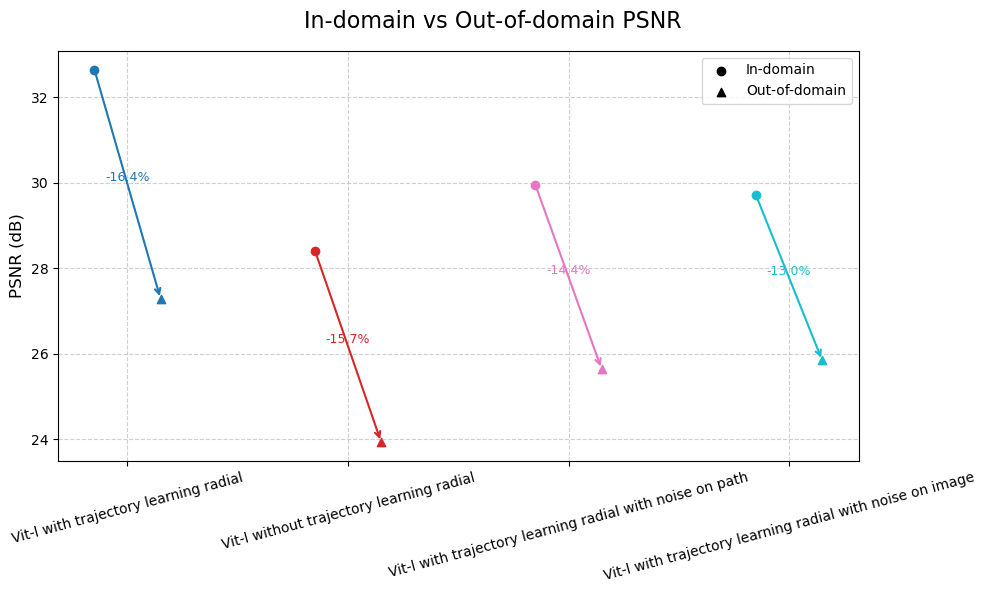

{'Vit-l with trajectory learning radial': {'in': np.float64(32.64136620170403),
  'out': np.float64(27.285178583125667),
  'pct_change': np.float64(-16.409201702772926)},
 'Vit-l without trajectory learning radial': {'in': np.float64(28.412772512620062),
  'out': np.float64(23.94050180625842),
  'pct_change': np.float64(-15.740353055567521)},
 'Vit-l with trajectory learning radial with noise on path': {'in': np.float64(29.942644537891155),
  'out': np.float64(25.643433894246353),
  'pct_change': np.float64(-14.35815276170524)},
 'Vit-l with trajectory learning radial with noise on image': {'in': np.float64(29.705266606638475),
  'out': np.float64(25.847805841366714),
  'pct_change': np.float64(-12.985780657527249)}}

In [27]:
compare_models_in_and_out(models_dict_radial_vit, test_loader, m4raw_loader)

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import common
from scipy.signal import savgol_filter

def smooth_curve(values, window=5, polyorder=2):
    """Applies Savitzky-Golay filter for smooth curves."""
    if len(values) >= window:
        return savgol_filter(values, window, polyorder)
    else:
        return values  # No smoothing if window is too large

def compare_models_psnr_vs_noise_radial(models_dict, dataloader, smooth_window=7):
    """
    Compares PSNR vs noise standard deviation for multiple models with smoothing.

    Args:
        models_dict: Dictionary of {'model_name': model} pairs
        dataloader: DataLoader providing (input_batch, target_batch)
        smooth_window: Window size for smoothing (default: 7)
    """
    from common.evaluate import psnr, ssim
    noise_stds = np.linspace(0, 320, 10)

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Model Comparison: PSNR vs Noise Standard Deviation", y=1.02, fontsize=16)

    colors = plt.cm.tab10(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd']
    line_styles = ['-', '--', ':', '-.']

    results = {}

    for i, (model_name, model) in enumerate(models_dict.items()):
        print(f"\nTesting model: {model_name}")
        psnr_values_per_std = {std: [] for std in noise_stds}

        initial_trajectory = model.module.subsampling.x.clone()

        for std in tqdm(noise_stds):
            total_psnr = 0
            num_batches = 0

            for input_batch, target_batch, _, _, _, _ in dataloader:
                input_batch, target_batch = input_batch.to("cuda"), target_batch.to("cuda")
                noise = torch.randn_like(initial_trajectory) * std
                noisy_traj = torch.clamp(initial_trajectory + noise, -160, 160)

                with torch.no_grad():
                    model.module.subsampling.x.data = noisy_traj
                    output = model(input_batch.unsqueeze(1))
                    psnr_val = psnr(target_batch.cpu().numpy(), output.detach().cpu().numpy())


                total_psnr += psnr_val
                num_batches += 1

            avg_psnr = total_psnr / num_batches
            psnr_values_per_std[std].append(avg_psnr)

        # Restore original trajectory
        model.module.subsampling.x.data = initial_trajectory

        # Average PSNR values and apply smoothing
        avg_psnr_values = [np.mean(psnr_values_per_std[std]) for std in noise_stds]
        print(avg_psnr_values)
        smoothed_psnr = smooth_curve(avg_psnr_values, window=smooth_window)

        ax.plot(noise_stds, smoothed_psnr,
                label=model_name,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                linestyle=line_styles[i % len(line_styles)])

    ax.set_xlabel('Noise Standard Deviation', fontsize=12)
    ax.set_ylabel('PSNR (dB)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.show()
    return results


Testing model: Unet without trajectory learning radial


100%|██████████| 10/10 [01:21<00:00,  8.13s/it]


[np.float64(27.983176142867862), np.float64(21.32112067321719), np.float64(19.394037992473624), np.float64(18.140218895006225), np.float64(17.00299369689041), np.float64(16.19033141570404), np.float64(15.79971081681703), np.float64(15.367145773533663), np.float64(15.247814833988283), np.float64(15.018649007358986)]

Testing model: Unet trajectory learning radial


100%|██████████| 10/10 [01:21<00:00,  8.12s/it]


[np.float64(35.41384830470871), np.float64(21.23669368738119), np.float64(19.07035527654213), np.float64(17.370651294569456), np.float64(16.348534994573324), np.float64(15.61548330898821), np.float64(15.24608261626679), np.float64(14.920838486638731), np.float64(14.786477819457936), np.float64(14.740190725115228)]

Testing model: Unet trajectory learning radial with noise on the path


100%|██████████| 10/10 [01:21<00:00,  8.11s/it]


[np.float64(28.5140668474715), np.float64(27.590898176541607), np.float64(26.384977601872446), np.float64(24.505602878275464), np.float64(22.39814598851085), np.float64(20.897586953822458), np.float64(19.565465118758105), np.float64(18.738900414802973), np.float64(17.989762992000234), np.float64(17.62132000728476)]

Testing model: Unet trajectory learning radial with noise on the image


100%|██████████| 10/10 [01:21<00:00,  8.18s/it]


[np.float64(33.564148746236654), np.float64(21.74959818075303), np.float64(19.378778672679413), np.float64(18.167637634132053), np.float64(16.971597757907464), np.float64(16.090102531480746), np.float64(15.653497509051027), np.float64(15.440459445902555), np.float64(15.20486317954504), np.float64(15.080718313849369)]

Testing model: Unet with adv trajectory learning


100%|██████████| 10/10 [01:21<00:00,  8.11s/it]


[np.float64(29.394297453633815), np.float64(25.300875237510983), np.float64(22.716173588053522), np.float64(21.222902954483345), np.float64(19.74591956415542), np.float64(18.37551834525156), np.float64(17.353841950004576), np.float64(16.599440995124308), np.float64(16.270789603551638), np.float64(15.97273013900294)]


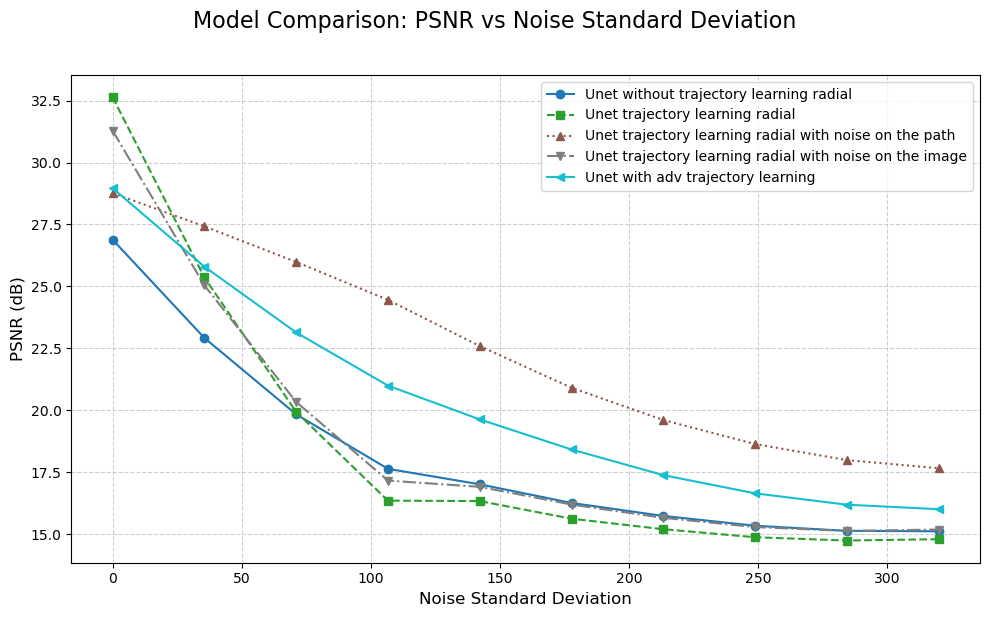

{}

In [13]:
compare_models_psnr_vs_noise_radial(models_dict_radial_unet, dev_loader)

In [35]:
%matplotlib inline

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from scipy.signal import savgol_filter
import common

def smooth_curve(values, window=5, polyorder=2):
    """Applies Savitzky-Golay filter for smooth curves."""
    if len(values) >= window:
        return savgol_filter(values, window, polyorder)
    else:
        return values  # No smoothing if window is too large

def compare_models_psnr_vs_noise_image(models_dict, dataloader, smooth_window=7):
    """
    Compares PSNR vs input image noise standard deviation for multiple models with smoothing.

    Args:
        models_dict: Dictionary of {'model_name': model} pairs
        dataloader: DataLoader providing (input_batch, target_batch)
        smooth_window: Window size for smoothing (default: 7)
    """
    from common.evaluate import psnr, ssim

    noise_stds = np.logspace(-6, -4, 5)

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Model Comparison: PSNR vs Input Noise Standard Deviation", y=1.02, fontsize=16)

    colors = plt.cm.tab10(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd']
    line_styles = ['-', '--', ':', '-.']

    results = {}

    for i, (model_name, model) in enumerate(models_dict.items()):
        print(f"\nTesting model: {model_name}")
        psnr_values_per_std = {std: [] for std in noise_stds}


        for std in tqdm(noise_stds, desc=f"{model_name} Noise Sweep"):
            print(std)
            total_psnr = 0
            num_batches = 0

            for input_batch, target_batch, _, _, _, _ in dataloader:
                input_batch, target_batch = input_batch.to("cuda"), target_batch.to("cuda")

                noise = torch.randn_like(input_batch) * std
                noisy_input = input_batch + noise

                with torch.no_grad():
                    output = model(noisy_input.unsqueeze(1))
                    psnr_val = psnr(target_batch.cpu().numpy(), output.detach().cpu().numpy())

                total_psnr += psnr_val
                num_batches += 1

            avg_psnr = total_psnr / num_batches
            psnr_values_per_std[std].append(avg_psnr)
            print(avg_psnr)

        # Average PSNR values and apply smoothing
        avg_psnr_values = [np.mean(psnr_values_per_std[std]) for std in noise_stds]
        print("PSNR values:", avg_psnr_values)

        smoothed_psnr = smooth_curve(avg_psnr_values, window=smooth_window)

        ax.plot(noise_stds, smoothed_psnr,
                label=model_name,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                linestyle=line_styles[i % len(line_styles)])

    ax.set_xlabel('Input Noise Standard Deviation', fontsize=12)
    ax.set_ylabel('PSNR (dB)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    return results



Testing model: Unet trajectory learning radial


Unet trajectory learning radial Noise Sweep:   0%|          | 0/5 [00:00<?, ?it/s]

1e-06


Unet trajectory learning radial Noise Sweep:  20%|██        | 1/5 [00:19<01:16, 19.22s/it]

32.95645418989005
3.162277660168379e-06


Unet trajectory learning radial Noise Sweep:  40%|████      | 2/5 [00:35<00:53, 17.76s/it]

33.03599826289612
9.999999999999999e-06


Unet trajectory learning radial Noise Sweep:  60%|██████    | 3/5 [00:52<00:34, 17.40s/it]

31.029498614614585
3.1622776601683795e-05


Unet trajectory learning radial Noise Sweep:  80%|████████  | 4/5 [01:09<00:17, 17.00s/it]

25.40723834966502
0.0001


Unet trajectory learning radial Noise Sweep: 100%|██████████| 5/5 [01:28<00:00, 17.64s/it]


20.319676066392255
PSNR values: [np.float64(32.95645418989005), np.float64(33.03599826289612), np.float64(31.029498614614585), np.float64(25.40723834966502), np.float64(20.319676066392255)]

Testing model: Vit-l with trajectory learning radial


Vit-l with trajectory learning radial Noise Sweep:   0%|          | 0/5 [00:00<?, ?it/s]

1e-06


Vit-l with trajectory learning radial Noise Sweep:  20%|██        | 1/5 [00:20<01:21, 20.31s/it]

32.733939067138614
3.162277660168379e-06


Vit-l with trajectory learning radial Noise Sweep:  40%|████      | 2/5 [00:42<01:03, 21.19s/it]

32.68853398911801
9.999999999999999e-06


Vit-l with trajectory learning radial Noise Sweep:  60%|██████    | 3/5 [01:03<00:42, 21.39s/it]

32.24926563123516
3.1622776601683795e-05


Vit-l with trajectory learning radial Noise Sweep:  80%|████████  | 4/5 [01:24<00:21, 21.01s/it]

28.596267253911176
0.0001


Vit-l with trajectory learning radial Noise Sweep: 100%|██████████| 5/5 [01:48<00:00, 21.66s/it]


20.40901181104315
PSNR values: [np.float64(32.733939067138614), np.float64(32.68853398911801), np.float64(32.24926563123516), np.float64(28.596267253911176), np.float64(20.40901181104315)]

Testing model: Vit-l without trajectory learning radial


Vit-l without trajectory learning radial Noise Sweep:   0%|          | 0/5 [00:00<?, ?it/s]

1e-06


Vit-l without trajectory learning radial Noise Sweep:  20%|██        | 1/5 [00:20<01:21, 20.30s/it]

28.25852849670309
3.162277660168379e-06


Vit-l without trajectory learning radial Noise Sweep:  40%|████      | 2/5 [00:40<01:00, 20.31s/it]

28.256383332966408
9.999999999999999e-06


Vit-l without trajectory learning radial Noise Sweep:  60%|██████    | 3/5 [01:01<00:40, 20.38s/it]

28.165118618341545
3.1622776601683795e-05


Vit-l without trajectory learning radial Noise Sweep:  80%|████████  | 4/5 [01:21<00:20, 20.32s/it]

27.380934042394326
0.0001


Vit-l without trajectory learning radial Noise Sweep: 100%|██████████| 5/5 [01:41<00:00, 20.35s/it]


23.53166623641508
PSNR values: [np.float64(28.25852849670309), np.float64(28.256383332966408), np.float64(28.165118618341545), np.float64(27.380934042394326), np.float64(23.53166623641508)]

Testing model: Unet trajectory learning radial with noise on the path


Unet trajectory learning radial with noise on the path Noise Sweep:   0%|          | 0/5 [00:00<?, ?it/s]

1e-06


Unet trajectory learning radial with noise on the path Noise Sweep:  20%|██        | 1/5 [00:16<01:05, 16.44s/it]

26.498935013605067
3.162277660168379e-06


Unet trajectory learning radial with noise on the path Noise Sweep:  40%|████      | 2/5 [00:32<00:48, 16.11s/it]

26.37552258570715
9.999999999999999e-06


Unet trajectory learning radial with noise on the path Noise Sweep:  60%|██████    | 3/5 [00:50<00:33, 16.99s/it]

25.937708812115176
3.1622776601683795e-05


Unet trajectory learning radial with noise on the path Noise Sweep:  80%|████████  | 4/5 [01:07<00:17, 17.16s/it]

23.74259944983559
0.0001


Unet trajectory learning radial with noise on the path Noise Sweep: 100%|██████████| 5/5 [01:23<00:00, 16.69s/it]


19.372731963822808
PSNR values: [np.float64(26.498935013605067), np.float64(26.37552258570715), np.float64(25.937708812115176), np.float64(23.74259944983559), np.float64(19.372731963822808)]

Testing model: Unet trajectory learning cartesian


Unet trajectory learning cartesian Noise Sweep:   0%|          | 0/5 [00:00<?, ?it/s]

1e-06


Unet trajectory learning cartesian Noise Sweep:  20%|██        | 1/5 [00:09<00:38,  9.60s/it]

32.93973402410082
3.162277660168379e-06


Unet trajectory learning cartesian Noise Sweep:  40%|████      | 2/5 [00:19<00:29,  9.82s/it]

32.51335950802216
9.999999999999999e-06


Unet trajectory learning cartesian Noise Sweep:  60%|██████    | 3/5 [00:29<00:19,  9.88s/it]

29.721001166983363
3.1622776601683795e-05


Unet trajectory learning cartesian Noise Sweep:  80%|████████  | 4/5 [00:39<00:09,  9.85s/it]

24.530906280577437
0.0001


Unet trajectory learning cartesian Noise Sweep: 100%|██████████| 5/5 [00:49<00:00,  9.91s/it]


19.36346821039145
PSNR values: [np.float64(32.93973402410082), np.float64(32.51335950802216), np.float64(29.721001166983363), np.float64(24.530906280577437), np.float64(19.36346821039145)]

Testing model: Vit-l with trajectory learning cartesian


Vit-l with trajectory learning cartesian Noise Sweep:   0%|          | 0/5 [00:00<?, ?it/s]

1e-06


Vit-l with trajectory learning cartesian Noise Sweep:  20%|██        | 1/5 [00:11<00:45, 11.46s/it]

34.48544525656774
3.162277660168379e-06


Vit-l with trajectory learning cartesian Noise Sweep:  40%|████      | 2/5 [00:22<00:33, 11.32s/it]

33.99555036054002
9.999999999999999e-06


Vit-l with trajectory learning cartesian Noise Sweep:  60%|██████    | 3/5 [00:34<00:22, 11.47s/it]

31.40616674417651
3.1622776601683795e-05


Vit-l with trajectory learning cartesian Noise Sweep:  80%|████████  | 4/5 [00:45<00:11, 11.54s/it]

25.87948325633057
0.0001


Vit-l with trajectory learning cartesian Noise Sweep: 100%|██████████| 5/5 [00:57<00:00, 11.48s/it]


18.075798489719386
PSNR values: [np.float64(34.48544525656774), np.float64(33.99555036054002), np.float64(31.40616674417651), np.float64(25.87948325633057), np.float64(18.075798489719386)]

Testing model: Vit-l without trajectory learning cartesian


Vit-l without trajectory learning cartesian Noise Sweep:   0%|          | 0/5 [00:00<?, ?it/s]

1e-06


Vit-l without trajectory learning cartesian Noise Sweep:  20%|██        | 1/5 [00:11<00:45, 11.46s/it]

34.052416586945476
3.162277660168379e-06


Vit-l without trajectory learning cartesian Noise Sweep:  40%|████      | 2/5 [00:23<00:34, 11.66s/it]

33.64150410777258
9.999999999999999e-06


Vit-l without trajectory learning cartesian Noise Sweep:  60%|██████    | 3/5 [00:34<00:23, 11.54s/it]

31.003457102700445
3.1622776601683795e-05


Vit-l without trajectory learning cartesian Noise Sweep:  80%|████████  | 4/5 [00:46<00:11, 11.67s/it]

26.091594103102143
0.0001


Vit-l without trajectory learning cartesian Noise Sweep: 100%|██████████| 5/5 [00:58<00:00, 11.62s/it]


19.604531975163507
PSNR values: [np.float64(34.052416586945476), np.float64(33.64150410777258), np.float64(31.003457102700445), np.float64(26.091594103102143), np.float64(19.604531975163507)]

Testing model: Vit-l with trajectory learning cartesian with noise on image


Vit-l with trajectory learning cartesian with noise on image Noise Sweep:   0%|          | 0/5 [00:00<?, ?it/s]

1e-06


Vit-l with trajectory learning cartesian with noise on image Noise Sweep:  20%|██        | 1/5 [00:11<00:44, 11.12s/it]

29.107653188997123
3.162277660168379e-06


Vit-l with trajectory learning cartesian with noise on image Noise Sweep:  40%|████      | 2/5 [00:22<00:33, 11.23s/it]

29.099860291914663
9.999999999999999e-06


Vit-l with trajectory learning cartesian with noise on image Noise Sweep:  60%|██████    | 3/5 [00:33<00:22, 11.27s/it]

28.98478956074558
3.1622776601683795e-05


Vit-l with trajectory learning cartesian with noise on image Noise Sweep:  80%|████████  | 4/5 [00:45<00:11, 11.37s/it]

28.451733561757354
0.0001


Vit-l with trajectory learning cartesian with noise on image Noise Sweep: 100%|██████████| 5/5 [00:56<00:00, 11.34s/it]


24.980771593626958
PSNR values: [np.float64(29.107653188997123), np.float64(29.099860291914663), np.float64(28.98478956074558), np.float64(28.451733561757354), np.float64(24.980771593626958)]

Testing model: Unet trajectory learning cartesian with noise on image


Unet trajectory learning cartesian with noise on image Noise Sweep:   0%|          | 0/5 [00:00<?, ?it/s]

1e-06


Unet trajectory learning cartesian with noise on image Noise Sweep:  20%|██        | 1/5 [00:09<00:38,  9.64s/it]

29.471113736185814
3.162277660168379e-06


Unet trajectory learning cartesian with noise on image Noise Sweep:  40%|████      | 2/5 [00:19<00:29,  9.87s/it]

29.655014567913167
9.999999999999999e-06


Unet trajectory learning cartesian with noise on image Noise Sweep:  60%|██████    | 3/5 [00:29<00:19, 10.00s/it]

29.467591019713275
3.1622776601683795e-05


Unet trajectory learning cartesian with noise on image Noise Sweep:  80%|████████  | 4/5 [00:39<00:10, 10.00s/it]

28.77535290929614
0.0001


Unet trajectory learning cartesian with noise on image Noise Sweep: 100%|██████████| 5/5 [00:49<00:00,  9.99s/it]

25.7086102699993
PSNR values: [np.float64(29.471113736185814), np.float64(29.655014567913167), np.float64(29.467591019713275), np.float64(28.77535290929614), np.float64(25.7086102699993)]


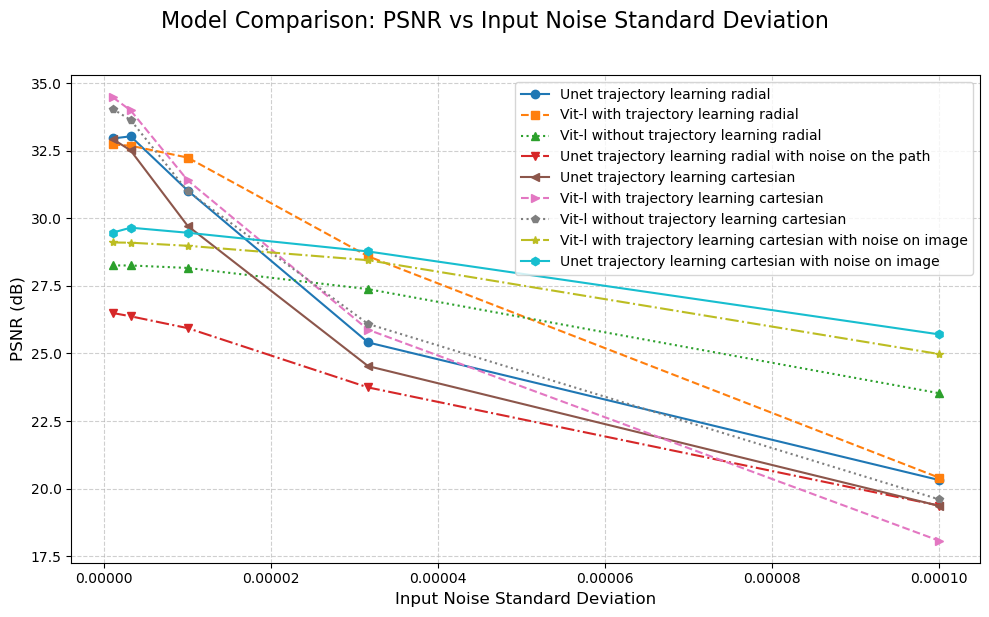

{}

In [73]:
compare_models_psnr_vs_noise_image(models_dict_all, dev_loader)

In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import savgol_filter
from common.evaluate import psnr
import fastmri


def smooth_curve(values, window=5, polyorder=2):
    if len(values) >= window:
        return savgol_filter(values, window, polyorder)
    else:
        return values


def perturb_Bimask(Bimask, move_std=10):
    _, _, H, _, _ = Bimask.shape
    Bimask = Bimask.clone()
    perturbed = Bimask.clone()

    selected_rows = (Bimask[0, 0, :, 0, 0] == 1).nonzero(as_tuple=False).squeeze(-1)
    occupied = set(selected_rows.tolist())

    for y in selected_rows.tolist():
        for _ in range(10):
            eps = torch.randn((1,))
            sample = move_std * eps
            shift = int(round(sample.item()))
            y_new = y + shift
            if 0 <= y_new < H and y_new not in occupied:
                perturbed[0, 0, y, 0, 0] = 0
                perturbed[0, 0, y_new, 0, 0] = 1
                occupied.remove(y)
                occupied.add(y_new)
                break

    noise_mask = (perturbed != Bimask).float()
    return noise_mask

import torch

def perturb_Bimask_center_boundary_shift(
    Bimask: torch.Tensor,
    num_move: int,
    center_fraction: float = 0.04,
):
    """
    Move up to `num_move` active lines closest to (but NOT inside) the central fraction band
    to the extremes of k-space (top or bottom), preserving the center band.

    Args:
        Bimask: Tensor shape [1, 1, H, 1, 1] with binary sampling mask (1 = sampled line).
        num_move: Number of lines to move.
        center_fraction: Fraction of total height defining protected central band.

    Returns:
        noise_mask: (same shape) binary where 1 indicates a changed position (line moved).
        perturbed:  The new perturbed mask.
        moved_pairs: List of tuples (old_index, new_index).
    """
    assert Bimask.ndim == 5, "Expected shape [1,1,H,1,1]"
    _, _, H, _, _ = Bimask.shape
    if num_move <= 0:
        return torch.zeros_like(Bimask), Bimask.clone(), []

    # ---- Clone base ----
    original = Bimask.clone()
    perturbed = Bimask.clone()

    # ---- Central band definition ----
    center_line = H // 2
    band_width = max(1, int(round(H * center_fraction)))
    # Ensure band_width does not exceed H
    band_width = min(band_width, H)
    band_start = center_line - band_width // 2
    band_end = band_start + band_width
    band_start = max(0, band_start)
    band_end = min(H, band_end)

    # Active (sampled) lines
    active_lines = (original[0, 0, :, 0, 0] == 1).nonzero(as_tuple=False).squeeze(-1)

    # Candidate lines: outside the protected band
    candidates = active_lines[
        (active_lines < band_start) | (active_lines >= band_end)
    ]

    if candidates.numel() == 0:
        return torch.zeros_like(Bimask), Bimask.clone(), []

    # Compute distance to band boundary
    # For lines above: distance to band_start
    # For lines below: distance to (band_end - 1)
    dist_to_start = torch.abs(candidates - band_start)
    dist_to_endm1 = torch.abs(candidates - (band_end - 1))
    distance_to_band = torch.minimum(dist_to_start, dist_to_endm1)

    # Secondary tie-breaker: distance to center line
    dist_to_center = torch.abs(candidates - center_line)

    # Sort by (distance_to_band, dist_to_center, index)
    sort_keys = torch.stack([distance_to_band, dist_to_center, candidates.float()], dim=1)
    # Lexicographic sort: we can convert to tuple of tensors in order
    # Easiest: sort by a combined key; but stable: use argsort multiple times in reverse order.
    # Instead build a single scalar key with large multipliers (safe since distances < H)
    # key = distance_to_band * (H*H) + dist_to_center * H + candidates
    key = (distance_to_band * (H * H)) + (dist_to_center * H) + candidates
    order = torch.argsort(key)
    ordered_candidates = candidates[order]

    # Occupancy tracking
    occupied = set(active_lines.tolist())
    protected_set = set(range(band_start, band_end))

    moved_pairs = []

    def find_lowest_free():
        for idx in range(0, H):
            if idx in protected_set:
                continue
            if idx not in occupied:
                return idx
        return None

    def find_highest_free():
        for idx in range(H - 1, -1, -1):
            if idx in protected_set:
                continue
            if idx not in occupied:
                return idx
        return None

    moves_done = 0
    for y in ordered_candidates.tolist():
        if moves_done >= num_move:
            break
        if y not in occupied:
            continue  # might already have been moved indirectly (unlikely but safe)

        # Remove current line
        perturbed[0, 0, y, 0, 0] = 0
        occupied.remove(y)

        # Decide new extreme position
        if y < center_line:
            new_y = find_lowest_free()
        else:
            new_y = find_highest_free()

        if new_y is None:
            # Revert if failed
            perturbed[0, 0, y, 0, 0] = 1
            occupied.add(y)
            continue

        perturbed[0, 0, new_y, 0, 0] = 1
        occupied.add(new_y)
        moved_pairs.append((y, new_y))
        moves_done += 1

    noise_mask = (perturbed != original).float()
    return noise_mask

def compare_models_psnr_vs_mask_noise(models_dict, dataloader, type = "normal",smooth_window=5):
    """
    Compares PSNR vs mask perturbation noise std for multiple models.

    Args:
        models_dict: Dict of {'model_name': model}
        dataloader: DataLoader yielding (input_batch, target_batch, ...)
        bimask: torch.Tensor [1, 1, H, 1, 1], the original Bimask
        smooth_window: Smoothing window for PSNR plot
    """
    stds = [0, 1, 2, 3, 4, 5, 6 ,7 ,8 ,9 ,10] # You can change range as needed

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Model Comparison: PSNR vs Mask Perturbation Noise", fontsize=16)

    colors = plt.cm.tab10(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd']
    line_styles = ['-', '--', ':', '-.']

    results = {}

    for i, (model_name, model) in enumerate(models_dict.items()):
        print(f"\nTesting model: {model_name}")
        psnr_values_per_std = []

        for std in tqdm(stds, desc=f"{model_name} Mask Perturbation Sweep"):
            total_psnr = 0
            num_batches = 0

            for input_batch, target_batch, *_ in dataloader:
                input_batch = input_batch.to("cuda")
                target_batch = target_batch.to("cuda")
                bimask = model.module.subsampling.Bimask
                if type == "normal":
                    noise_mask_rand = perturb_Bimask(bimask, move_std=std)
                else:
                    noise_mask_rand = perturb_Bimask_center_boundary_shift(bimask, std)[0]
                noise_mask_rand = (
                    bimask * (1 - noise_mask_rand) +
                    (1 - bimask) * noise_mask_rand
                ).to(input_batch.device)
                input_c = fastmri.fft2c(input_batch)
                input_c_masked = input_c.unsqueeze(0) * noise_mask_rand
                input_c_masked = fastmri.ifft2c(input_c_masked)
                input_c_masked = transforms.complex_abs(input_c_masked)
                min_val = input_c_masked.amin(dim=(1, 2, 3), keepdim=True)
                max_val = input_c_masked.amax(dim=(1, 2, 3), keepdim=True)
                input_c_masked = (input_c_masked - min_val) / (max_val - min_val + 1e-8)  # Avoid divide-by-zero



                with torch.no_grad():
                    output = model.module.reconstruction_model(input_c_masked)
                    psnr_val = psnr(target_batch.squeeze().cpu().numpy(), output.squeeze().detach().cpu().numpy())

                total_psnr += psnr_val
                num_batches += 1

            avg_psnr = total_psnr / num_batches
            psnr_values_per_std.append(avg_psnr)
            print(f"std={std:.3f}, PSNR={avg_psnr:.3f}")

        smoothed_psnr = smooth_curve(psnr_values_per_std, window=smooth_window)
        results[model_name] = smoothed_psnr

        ax.plot(stds, smoothed_psnr,
                label=model_name,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                linestyle=line_styles[i % len(line_styles)])

    ax.set_xlabel('Mask Perturbation std (pixels)', fontsize=12)
    ax.set_ylabel('PSNR (dB)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    return results

In [55]:
def plot_trajectory(x):
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    ax.axis([-165, 165, -165, 165])
    for i in range(x.shape[0]):
        ax.plot(x[i, :, 0], x[i, :, 1])
    return fig

def mask_to_trajectory(mask):
    mask = np.squeeze(mask)
    x_values = [x for x in range(-160, 160)]

    trajectory = []
    for i in range(320):
        if mask[i].item() == True:
            for x in x_values:
                trajectory.append([x, i - 160])
    return torch.tensor(trajectory).reshape(-1, 320, 2)

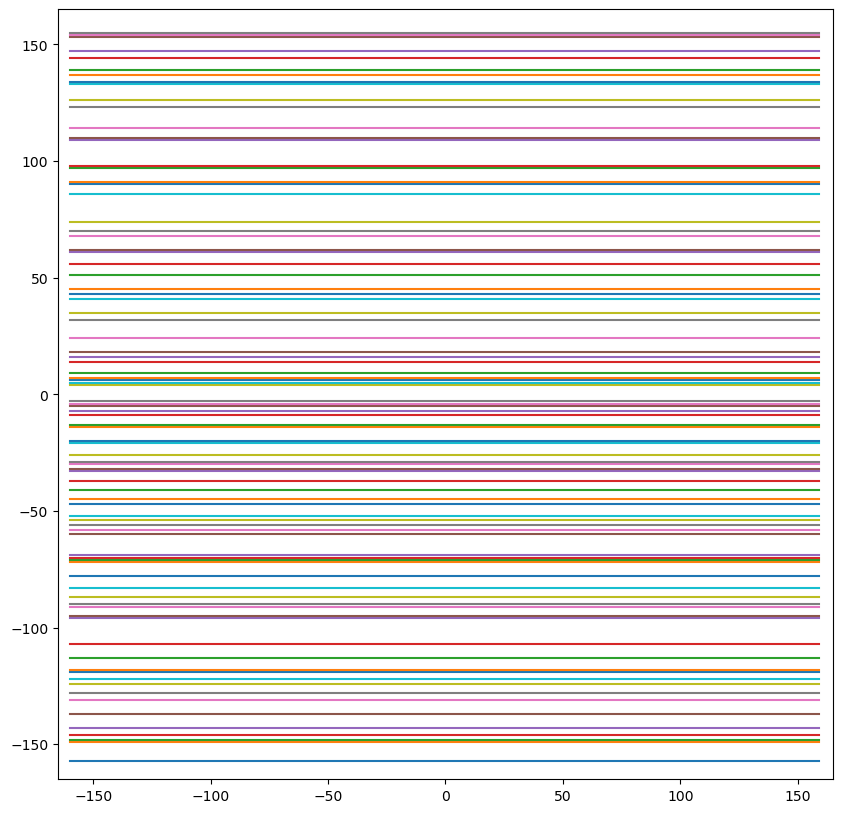

In [56]:
c = perturb_Bimask(Unet_trajectory_learning_cartesian.module.subsampling.Bimask, 1000)
mask = (Unet_trajectory_learning_cartesian.module.subsampling.Bimask) * (1 - c) + c * (1 - Unet_trajectory_learning_cartesian.module.subsampling.Bimask)
plot_trajectory(mask_to_trajectory(mask))


Testing model: Unet trajectory learning cartesian


Unet trajectory learning cartesian Mask Perturbation Sweep:   9%|▉         | 1/11 [00:05<00:57,  5.72s/it]

std=0.000, PSNR=35.139


Unet trajectory learning cartesian Mask Perturbation Sweep:  18%|█▊        | 2/11 [00:11<00:50,  5.62s/it]

std=1.000, PSNR=34.430


Unet trajectory learning cartesian Mask Perturbation Sweep:  27%|██▋       | 3/11 [00:16<00:45,  5.64s/it]

std=2.000, PSNR=32.955


Unet trajectory learning cartesian Mask Perturbation Sweep:  36%|███▋      | 4/11 [00:22<00:39,  5.67s/it]

std=3.000, PSNR=32.343


Unet trajectory learning cartesian Mask Perturbation Sweep:  45%|████▌     | 5/11 [00:28<00:34,  5.70s/it]

std=4.000, PSNR=31.217


Unet trajectory learning cartesian Mask Perturbation Sweep:  55%|█████▍    | 6/11 [00:34<00:28,  5.74s/it]

std=5.000, PSNR=30.690


Unet trajectory learning cartesian Mask Perturbation Sweep:  64%|██████▎   | 7/11 [00:39<00:22,  5.72s/it]

std=6.000, PSNR=29.880


Unet trajectory learning cartesian Mask Perturbation Sweep:  73%|███████▎  | 8/11 [00:45<00:17,  5.73s/it]

std=7.000, PSNR=29.440


Unet trajectory learning cartesian Mask Perturbation Sweep:  82%|████████▏ | 9/11 [00:51<00:11,  5.73s/it]

std=8.000, PSNR=28.829


Unet trajectory learning cartesian Mask Perturbation Sweep:  91%|█████████ | 10/11 [00:57<00:05,  5.70s/it]

std=9.000, PSNR=28.508


Unet trajectory learning cartesian Mask Perturbation Sweep: 100%|██████████| 11/11 [01:03<00:00,  5.73s/it]


std=10.000, PSNR=28.069

Testing model: Unet trajectory learning cartesian with noise on image


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:   9%|▉         | 1/11 [00:05<00:57,  5.71s/it]

std=0.000, PSNR=33.602


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:  18%|█▊        | 2/11 [00:11<00:50,  5.62s/it]

std=1.000, PSNR=33.021


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:  27%|██▋       | 3/11 [00:16<00:44,  5.57s/it]

std=2.000, PSNR=31.655


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:  36%|███▋      | 4/11 [00:22<00:39,  5.64s/it]

std=3.000, PSNR=31.071


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:  45%|████▌     | 5/11 [00:28<00:35,  5.84s/it]

std=4.000, PSNR=30.068


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:  55%|█████▍    | 6/11 [00:34<00:28,  5.80s/it]

std=5.000, PSNR=29.607


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:  64%|██████▎   | 7/11 [00:39<00:22,  5.69s/it]

std=6.000, PSNR=28.890


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:  73%|███████▎  | 8/11 [00:45<00:17,  5.72s/it]

std=7.000, PSNR=28.535


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:  82%|████████▏ | 9/11 [00:51<00:11,  5.75s/it]

std=8.000, PSNR=28.015


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep:  91%|█████████ | 10/11 [00:57<00:05,  5.72s/it]

std=9.000, PSNR=27.739


Unet trajectory learning cartesian with noise on image Mask Perturbation Sweep: 100%|██████████| 11/11 [01:02<00:00,  5.71s/it]


std=10.000, PSNR=27.345

Testing model: Unet trajectory learning cartesian with noise on path 


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:   9%|▉         | 1/11 [00:05<00:56,  5.61s/it]

std=0.000, PSNR=30.160


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:  18%|█▊        | 2/11 [00:11<00:50,  5.60s/it]

std=1.000, PSNR=30.123


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:  27%|██▋       | 3/11 [00:17<00:45,  5.71s/it]

std=2.000, PSNR=29.879


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:  36%|███▋      | 4/11 [00:22<00:39,  5.70s/it]

std=3.000, PSNR=29.681


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:  45%|████▌     | 5/11 [00:28<00:33,  5.65s/it]

std=4.000, PSNR=29.347


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:  55%|█████▍    | 6/11 [00:33<00:28,  5.62s/it]

std=5.000, PSNR=28.896


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:  64%|██████▎   | 7/11 [00:39<00:22,  5.59s/it]

std=6.000, PSNR=28.459


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:  73%|███████▎  | 8/11 [00:45<00:16,  5.62s/it]

std=7.000, PSNR=28.246


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:  82%|████████▏ | 9/11 [00:50<00:11,  5.68s/it]

std=8.000, PSNR=27.861


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep:  91%|█████████ | 10/11 [00:56<00:05,  5.72s/it]

std=9.000, PSNR=27.495


Unet trajectory learning cartesian with noise on path  Mask Perturbation Sweep: 100%|██████████| 11/11 [01:02<00:00,  5.67s/it]

std=10.000, PSNR=27.144


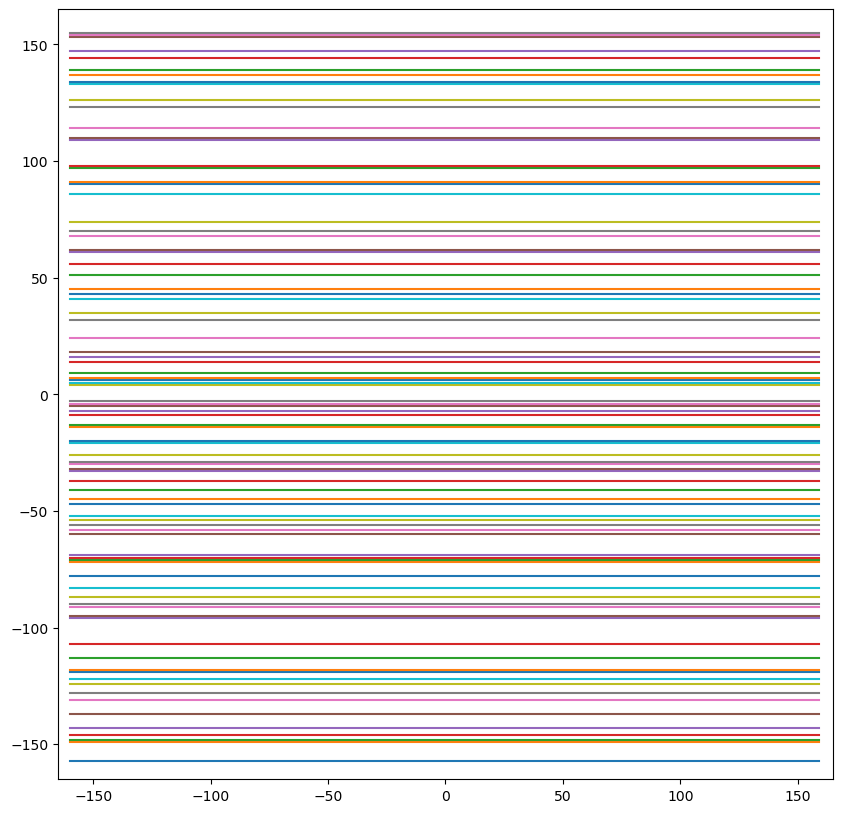

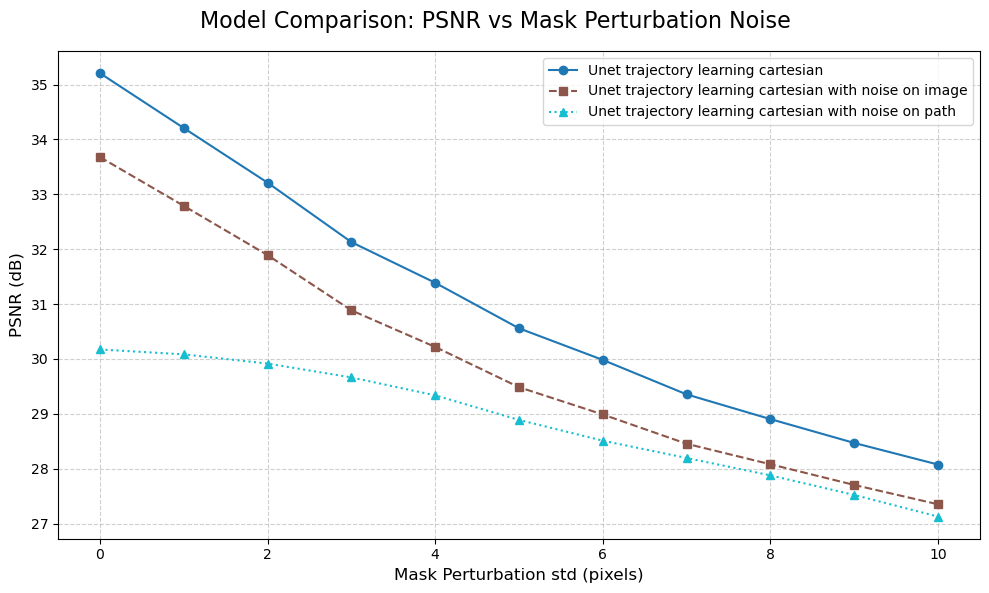

{'Unet trajectory learning cartesian': array([35.20761037, 34.20779965, 33.21243739, 32.12953576, 31.38820469,
        30.55852151, 29.98225645, 29.35423606, 28.90382947, 28.46905942,
        28.07566475]),
 'Unet trajectory learning cartesian with noise on image': array([33.67844107, 32.78969661, 31.89226275, 30.88601342, 30.21907503,
        29.48562869, 28.98812745, 28.45460084, 28.0808656 , 27.70425856,
        27.35148389]),
 'Unet trajectory learning cartesian with noise on path ': array([30.1729274 , 30.08374654, 29.91616244, 29.66354316, 29.33725303,
        28.88905749, 28.51098141, 28.19581214, 27.87815852, 27.52175688,
        27.12844317])}

In [57]:
compare_models_psnr_vs_mask_noise(models_dict_cartesian_unet, dev_loader, "pgd")

In [16]:
def pgd_attack_on_trajectory(model, input_tensor, target_tensor, epsilon, alpha=1, steps=1, norm='linf'):
    """
    PGD attack directly on the trajectory perturbation (not on the trajectory itself).
    """
    from pytorch_nufft.nufft2 import nufft, nufft_adjoint
    device = input_tensor.device
    model = model.to(device)
    input_tensor = input_tensor.to(device)
    target_tensor = target_tensor.to(device)

    # Clone original trajectory
    original_trajectory = model.module.subsampling.x.detach().clone()

    # Initialize perturbation as the variable we optimize
    perturbation = torch.zeros_like(original_trajectory, device=device, requires_grad=True)

    lowest_psnr = float('inf')
    best_perturbation = torch.zeros_like(perturbation)

    for step in range(steps + 1):
        # Apply current perturbation to trajectory
        perturbed_trajectory = torch.clamp(original_trajectory + perturbation, -160, 160)

        # Inject into model
        x_full = perturbed_trajectory.reshape(-1, 2)

        input = input_tensor.unsqueeze(0).permute(0, 1, 4, 2, 3)
        sub_ksp = nufft(input, x_full)
        output = nufft_adjoint(sub_ksp, x_full, input.shape)
        output = output.permute(0, 1, 3, 4, 2)
        output = transforms.complex_abs(output)
        output = normalize(output)

        # Forward pass
        output = model.module.reconstruction_model(output)
        target = target_tensor.view_as(output) if output.shape != target_tensor.shape else target_tensor
        loss = F.l1_loss(output, target)

        # Track lowest PSNR
        current_psnr = psnr(target.detach().cpu().numpy(), output.detach().cpu().numpy())
        if current_psnr < lowest_psnr:
            lowest_psnr = current_psnr
            best_perturbation = perturbation.detach().clone()

        if step == steps:
            break

        # Backward: compute gradient w.r.t. perturbation
        if perturbation.grad is not None:
            perturbation.grad.zero_()
        loss.backward()

        # Update perturbation using its own gradient
        grad = perturbation.grad

        if norm == 'linf':
            perturbation.data += alpha * grad.sign()
            perturbation.data = project_linf(perturbation.data, epsilon)
        else:
            raise ValueError(f"Unsupported norm: {norm}")


    # Restore original trajectory
    return lowest_psnr

# Projection functions (same as provided)
def project_linf(perturbation, epsilon):
    return torch.clamp(perturbation, -epsilon, epsilon)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

def compare_models_psnr_vs_pgd_epsilon(models_dict, dataloader, epsilons=None, alpha=1, steps=1, norm='linf', smooth_window=5):
    """
    Compares PSNR vs PGD epsilon for multiple models using trajectory attacks.

    Args:
        models_dict: Dict of {'model_name': model}
        dataloader: DataLoader yielding (input_batch, target_batch, ...)
        epsilons: List of epsilon values to test (default: [0, 0.5, 1, 2, 4, 8])
        alpha: PGD step size
        steps: PGD steps
        norm: Norm type ('linf')
        smooth_window: Not used here but could smooth curves if needed.
    """
    if epsilons is None:
        epsilons = [1, 5, 10]

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle("Model Comparison: PSNR vs PGD Epsilon on Trajectory", fontsize=16)

    colors = plt.cm.tab10(np.linspace(0, 1, len(models_dict)))
    markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd']
    line_styles = ['-', '--', ':', '-.']

    results = {}

    for i, (model_name, model) in enumerate(models_dict.items()):
        print(f"\nTesting model: {model_name}")
        psnr_values_per_eps = []

        for eps in tqdm(epsilons, desc=f"{model_name} PGD Epsilon Sweep"):
            total_psnr = 0
            num_batches = 0

            for input_batch, target_batch, *_ in dataloader:
                input_batch = input_batch.to("cuda")
                target_batch = target_batch.to("cuda")

                # Run PGD attack on trajectory for this epsilon
                lowest_psnr = pgd_attack_on_trajectory(
                    model=model,
                    input_tensor=input_batch,
                    target_tensor=target_batch,
                    epsilon=eps,
                    alpha=alpha,
                    steps=steps,
                    norm=norm
                )
                total_psnr += lowest_psnr
                num_batches += 1

            avg_psnr = total_psnr / num_batches
            psnr_values_per_eps.append(avg_psnr)
            print(f"epsilon={eps:.3f}, PSNR={avg_psnr:.3f}")

        results[model_name] = psnr_values_per_eps

        ax.plot(epsilons, psnr_values_per_eps,
                label=model_name,
                color=colors[i % len(colors)],
                marker=markers[i % len(markers)],
                linestyle=line_styles[i % len(line_styles)])

    ax.set_xlabel('PGD Epsilon', fontsize=12)
    ax.set_ylabel('PSNR (dB)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

    return results



Testing model: Unet without trajectory learning radial


Unet without trajectory learning radial PGD Epsilon Sweep:  33%|███▎      | 1/3 [00:24<00:48, 24.41s/it]

epsilon=1.000, PSNR=24.609


Unet without trajectory learning radial PGD Epsilon Sweep:  67%|██████▋   | 2/3 [00:47<00:23, 23.54s/it]

epsilon=5.000, PSNR=24.572


Unet without trajectory learning radial PGD Epsilon Sweep: 100%|██████████| 3/3 [01:10<00:00, 23.50s/it]


epsilon=10.000, PSNR=24.498

Testing model: Unet trajectory learning radial


Unet trajectory learning radial PGD Epsilon Sweep:  33%|███▎      | 1/3 [00:23<00:46, 23.37s/it]

epsilon=1.000, PSNR=23.396


Unet trajectory learning radial PGD Epsilon Sweep:  67%|██████▋   | 2/3 [00:46<00:23, 23.28s/it]

epsilon=5.000, PSNR=23.536


Unet trajectory learning radial PGD Epsilon Sweep: 100%|██████████| 3/3 [01:08<00:00, 22.97s/it]


epsilon=10.000, PSNR=23.517

Testing model: Unet trajectory learning radial with noise on the path


Unet trajectory learning radial with noise on the path PGD Epsilon Sweep:  33%|███▎      | 1/3 [00:23<00:46, 23.26s/it]

epsilon=1.000, PSNR=26.638


Unet trajectory learning radial with noise on the path PGD Epsilon Sweep:  67%|██████▋   | 2/3 [00:46<00:23, 23.00s/it]

epsilon=5.000, PSNR=26.638


Unet trajectory learning radial with noise on the path PGD Epsilon Sweep: 100%|██████████| 3/3 [01:09<00:00, 23.03s/it]


epsilon=10.000, PSNR=26.565

Testing model: Unet trajectory learning radial with noise on the image


Unet trajectory learning radial with noise on the image PGD Epsilon Sweep:  33%|███▎      | 1/3 [00:23<00:47, 23.59s/it]

epsilon=1.000, PSNR=23.902


Unet trajectory learning radial with noise on the image PGD Epsilon Sweep:  67%|██████▋   | 2/3 [00:46<00:23, 23.41s/it]

epsilon=5.000, PSNR=23.876


Unet trajectory learning radial with noise on the image PGD Epsilon Sweep: 100%|██████████| 3/3 [01:11<00:00, 23.68s/it]


epsilon=10.000, PSNR=23.919

Testing model: Unet with adv trajectory learning


Unet with adv trajectory learning PGD Epsilon Sweep:  33%|███▎      | 1/3 [00:24<00:48, 24.02s/it]

epsilon=1.000, PSNR=28.041


Unet with adv trajectory learning PGD Epsilon Sweep:  67%|██████▋   | 2/3 [00:46<00:23, 23.34s/it]

epsilon=5.000, PSNR=27.999


Unet with adv trajectory learning PGD Epsilon Sweep: 100%|██████████| 3/3 [01:10<00:00, 23.48s/it]

epsilon=10.000, PSNR=28.016


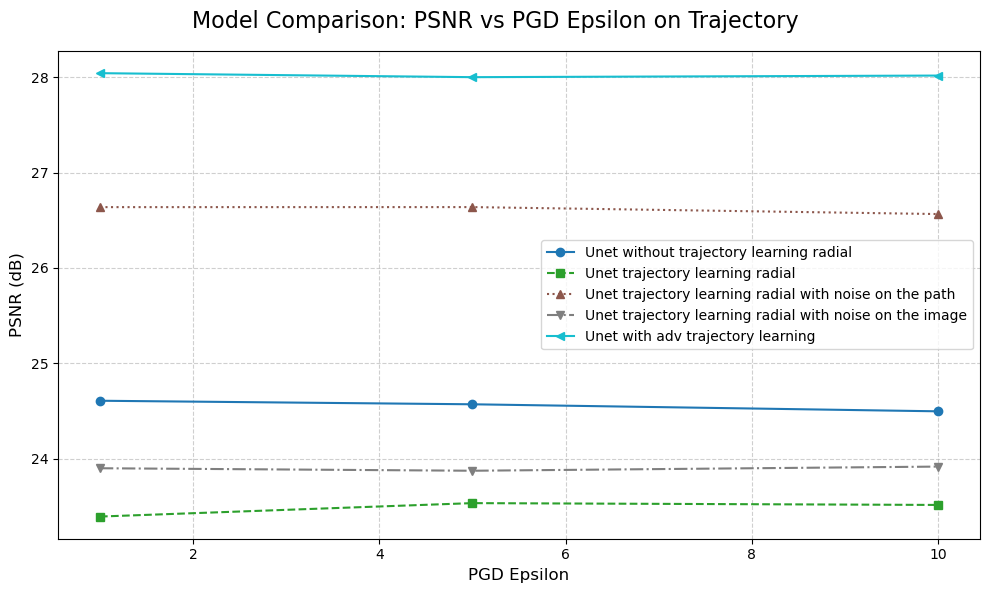

{'Unet without trajectory learning radial': [np.float64(24.608935790213806),
  np.float64(24.571823303151906),
  np.float64(24.498176092857104)],
 'Unet trajectory learning radial': [np.float64(23.39558360741023),
  np.float64(23.536287124839827),
  np.float64(23.51725513942101)],
 'Unet trajectory learning radial with noise on the path': [np.float64(26.63750906742454),
  np.float64(26.637895526998534),
  np.float64(26.564953919988408)],
 'Unet trajectory learning radial with noise on the image': [np.float64(23.90171860016575),
  np.float64(23.875552382110808),
  np.float64(23.919050344264875)],
 'Unet with adv trajectory learning': [np.float64(28.04108695976188),
  np.float64(27.99922001608061),
  np.float64(28.01593844952171)]}

In [17]:
compare_models_psnr_vs_pgd_epsilon(models_dict_radial_unet, dev_loader)